# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [1]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the libraries you will be using for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.0.2
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [4]:
# Try loading one file

df = pd.read_parquet('/content/drive/MyDrive/NYC_Taxi_analysis/dataset/2023-1.parquet')
df.info()
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/NYC_Taxi_analysis/dataset/2023-1.parquet'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
# read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir('/content/drive/MyDrive/NYC_Taxi_analysis/dataset')


# initialise an empty dataframe
combined_df = pd.DataFrame()
SAMPLE_FRACTION = 0.05  # 5% sampling
RANDOM_STATE = 42       # For reproducibility
TARGET_ROWS = 300000
MIN_SAMPLE = 1


# Create a list of all the twelve files to read
file_list = [f for f in os.listdir() if f.endswith('.parquet')]
total_rows = 0

for file_name in file_list:
  try:
    file_path = os.path.join(os.getcwd(), file_name)
    total_rows += pd.read_parquet(file_path).shape[0]
  except Exception as e:
    print(f"Error reading file {file_name}: {e}")

print(f"Total rows in all files: {total_rows}")


# Step 2: Calculate dynamic sampling fraction
SAMPLE_FRACTION = TARGET_ROWS / total_rows
print(f"Sampling fraction: {SAMPLE_FRACTION:.4f}")


# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        print(f"Processing {file_name}...")
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)
        month_df = pd.read_parquet(file_path)
        # Reading the current file

        month_df['tpep_pickup_datetime'] = pd.to_datetime(month_df['tpep_pickup_datetime'])
        month_df['date'] = month_df['tpep_pickup_datetime'].dt.date
        month_df['hour'] = month_df['tpep_pickup_datetime'].dt.hour
        grouped = month_df.groupby(['date', 'hour'])

         # Initialize sampled data for current month
        monthly_samples = pd.DataFrame()

        # Group by date and hour
        grouped = month_df.groupby(['date', 'hour'])

        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.


        # Loop through dates and then loop through every hour of each date
        for (date, hour), group in grouped:
            # Sample 5% of hourly data
            sample_size = max(MIN_SAMPLE, int(len(group) * SAMPLE_FRACTION))
            sample = group.sample(n=sample_size, random_state=RANDOM_STATE)
            monthly_samples = pd.concat([monthly_samples, sample])

        combined_df = pd.concat([combined_df, monthly_samples])

        print(f"Added {len(monthly_samples)} records from {file_name}")

            # Iterate through each hour of the selected date

                # Sample 5% of the hourly data randomly

                # add data of this hour to the dataframe

        # Concatenate the sampled data of all the dates to a single dataframe
        #df = # we initialised this empty DF earlier

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")
        continue

 # Finalize dataframe
combined_df = combined_df.reset_index(drop=True)
print("\nFinal combined dataframe shape:", combined_df.shape)

output_path = '/content/drive/MyDrive/NYC_Taxi_analysis/sampled_data.parquet'
combined_df.to_parquet(output_path, index=False)
print(f"Data saved to {output_path}")

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [6]:
# Store the df in csv/parquet
df2 = pd.read_parquet('/content/drive/MyDrive/NYC_Taxi_analysis/sampled_data.parquet')
df2.info()
df2.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295823 entries, 0 to 295822
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               295823 non-null  int64         
 1   tpep_pickup_datetime   295823 non-null  datetime64[us]
 2   tpep_dropoff_datetime  295823 non-null  datetime64[us]
 3   passenger_count        285981 non-null  float64       
 4   trip_distance          295823 non-null  float64       
 5   RatecodeID             285981 non-null  float64       
 6   store_and_fwd_flag     285981 non-null  object        
 7   PULocationID           295823 non-null  int64         
 8   DOLocationID           295823 non-null  int64         
 9   payment_type           295823 non-null  int64         
 10  fare_amount            295823 non-null  float64       
 11  extra                  295823 non-null  float64       
 12  mta_tax                295823 non-null  floa

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2008-12-31 15:05:04   2008-12-31 16:18:04              1.0   
1         2  2008-12-31 20:41:22   2008-12-31 21:03:22              1.0   
2         2  2009-01-01 00:06:35   2009-01-01 02:22:53              5.0   
3         2  2009-01-01 07:07:04   2009-01-01 08:33:41              1.0   
4         2  2023-08-31 23:56:01   2023-09-01 00:18:41              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0          11.77         1.0                  N           230           138   
1           6.46         1.0                  N           162           264   
2           4.48         1.0                  N           161            74   
3           3.07         1.0                  N           170           141   
4           3.11         1.0                  N           114           246   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             1  ...      0.5       16.45          6.94   
1             1  ...      0.5        6.78          0.00   
2             1  ...      0.5        6.55          0.00   
3             1  ...      0.5        4.90          0.00   
4             1  ...      0.5        0.00          0.00   

   improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
0                    1.0         98.69                   0.0          0.0   
1                    1.0         40.68                   2.5          0.0   
2                    1.0         32.75                   2.5          0.0   
3                    1.0         29.40                   2.5          0.0   
4                    1.0         26.20                   2.5          0.0   

         date  hour airport_fee  
0  2008-12-31    15         NaN  
1  2008-12-31    20         NaN  
2  2009-01-01     0         NaN  
3  2009-01-01     7         NaN  
4  2023-08-31    23         NaN  

[5 rows x 22 columns]

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [7]:
# Load the new data file
df2 = pd.read_parquet('/content/drive/MyDrive/NYC_Taxi_analysis/sampled_data.parquet')

In [8]:
df2.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2008-12-31 15:05:04   2008-12-31 16:18:04              1.0   
1         2  2008-12-31 20:41:22   2008-12-31 21:03:22              1.0   
2         2  2009-01-01 00:06:35   2009-01-01 02:22:53              5.0   
3         2  2009-01-01 07:07:04   2009-01-01 08:33:41              1.0   
4         2  2023-08-31 23:56:01   2023-09-01 00:18:41              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0          11.77         1.0                  N           230           138   
1           6.46         1.0                  N           162           264   
2           4.48         1.0                  N           161            74   
3           3.07         1.0                  N           170           141   
4           3.11         1.0                  N           114           246   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             1  ...      0.5       16.45          6.94   
1             1  ...      0.5        6.78          0.00   
2             1  ...      0.5        6.55          0.00   
3             1  ...      0.5        4.90          0.00   
4             1  ...      0.5        0.00          0.00   

   improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
0                    1.0         98.69                   0.0          0.0   
1                    1.0         40.68                   2.5          0.0   
2                    1.0         32.75                   2.5          0.0   
3                    1.0         29.40                   2.5          0.0   
4                    1.0         26.20                   2.5          0.0   

         date  hour airport_fee  
0  2008-12-31    15         NaN  
1  2008-12-31    20         NaN  
2  2009-01-01     0         NaN  
3  2009-01-01     7         NaN  
4  2023-08-31    23         NaN  

[5 rows x 22 columns]

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295823 entries, 0 to 295822
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               295823 non-null  int64         
 1   tpep_pickup_datetime   295823 non-null  datetime64[us]
 2   tpep_dropoff_datetime  295823 non-null  datetime64[us]
 3   passenger_count        285981 non-null  float64       
 4   trip_distance          295823 non-null  float64       
 5   RatecodeID             285981 non-null  float64       
 6   store_and_fwd_flag     285981 non-null  object        
 7   PULocationID           295823 non-null  int64         
 8   DOLocationID           295823 non-null  int64         
 9   payment_type           295823 non-null  int64         
 10  fare_amount            295823 non-null  float64       
 11  extra                  295823 non-null  float64       
 12  mta_tax                295823 non-null  floa

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [10]:
# Fix the index and drop any columns that are not needed
list(df2)
# 1. Can remove duplicates like airport_fee/Airport_fee
# 2. Store_and_fw_flag
# 3. To remove date and hour and keep tpep_pickup_datetime
# 4. total_amount // since surcharges analysis is not required
df2.columns
df2 = df2.drop(columns=['store_and_fwd_flag'])


In [11]:
print(df2.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee', 'date', 'hour', 'airport_fee'],
      dtype='object')


In [12]:
df2['airport_fee'].equals(df2['Airport_fee']) # not same
df2['airport_fee'] == df2['Airport_fee'] # not same
df2['diffs'] = abs(df2["airport_fee"] - df2["Airport_fee"]) > 0.1
df2['diffs'].value_counts()
print(df2['diffs'].values)
print(df2['Airport_fee'].values)
# df2[df2["diffs"] > 0.1]
# print(df2['airport_fee'].isnull().sum())
# print(df2['Airport_fee'].isnull().sum())
# df2['airport_fee'].equals(df2['Airport_fee'])  # Returns True or False
# df2['diffs'] = abs(df2["airport_fee"] - df2["Airport_fee"]) > 0.1
# df2[df2['diffs']]
# print(df2.airport_fee.describe())
# print(df2.Airport_fee.describe())

[False False False ... False False False]
[0. 0. 0. ... 0. 0. 0.]


**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [13]:
# Combine the two airport fee columns
print(df2.columns.tolist())
print(df2[['airport_fee','Airport_fee']].isnull().sum())
print(df2['airport_fee'].nunique(),df2["Airport_fee"].nunique())
# Check column names and data overlap
df2['Airport_fee_combined'] = df2['airport_fee'].fillna(df2['Airport_fee'])
df2['Airport_fee_combined'] = df2[['airport_fee', 'Airport_fee']].max(axis=1)
df2.drop(columns=['airport_fee', 'Airport_fee'], inplace=True)
# Combine columns (adjust case as needed)
# Drop original columns
# Example if columns are named differently
print(df2[['Airport_fee_combined']].head()) # Preview the final column
print("New column missing values:", df2['Airport_fee_combined'].isnull().sum())  # Ensure no data loss



['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'date', 'hour', 'airport_fee', 'diffs']
airport_fee    272674
Airport_fee     32991
dtype: int64
2 4
   Airport_fee_combined
0                   0.0
1                   0.0
2                   0.0
3                   0.0
4                   0.0
New column missing values: 9842


In [14]:
# print(df2.columns)          # Print column names
print(list(df2.columns))
print(df2.columns.tolist())
df2['Airport_fee_combined'].isnull().count()
print("Combined column nulls:", df2['Airport_fee_combined'].isnull().sum())

['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'date', 'hour', 'diffs', 'Airport_fee_combined']
['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'date', 'hour', 'diffs', 'Airport_fee_combined']
Combined column nulls: 9842


**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [15]:
# check where values of fare amount are negative
#df2.info()
negative_fare_count = (df2['fare_amount'] < 0).sum()
print(negative_fare_count)


0


Did you notice something different in the `RatecodeID` column for above records?

In [16]:
# Analyse RatecodeID for the negative fare amounts
negative_ratecodeID =(df2['fare_amount'] < 0).sum()
print(negative_ratecodeID)

0


In [17]:
# Find which columns have negative values
print("all the columns", df2.columns)
print(df2.dtypes)
numeric_df = df2.select_dtypes(include=['number'])
negative_columns = numeric_df.columns[(numeric_df < 0 ).any()].tolist()
print(negative_columns)

all the columns Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'date', 'hour', 'diffs',
       'Airport_fee_combined'],
      dtype='object')
VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge

In [18]:
# fix these negative values
negative_rows = df2['extra'] < 0
print(negative_rows)

# Identify numeric columns
numeric_df = df2.select_dtypes(include=['number'])

# Find columns with negative values
negative_columns = numeric_df.columns[(numeric_df < 0).any()].tolist()

# extracting all -ve values
negative_values_df = df2[negative_columns][df2[negative_columns]<0].dropna(how='all')

# show summary of negative values
print(negative_columns, negative_values_df.describe())

# columns with -ve values
#  extra, mta_tax , improvement_surcharge ,total_amount , congestion_surge , Airport_fee

df2[negative_columns] = df2[negative_columns].abs()
df2["total_amount_negative"] = df2["total_amount"]<0
df2["total_amount_negative"].value_counts()



0         False
1         False
2         False
3         False
4         False
          ...  
295818    False
295819    False
295820    False
295821    False
295822    False
Name: extra, Length: 295823, dtype: bool
['extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee_combined']        extra  mta_tax  improvement_surcharge  total_amount  \
count    1.0     11.0                   11.0     11.000000   
mean    -2.5     -0.5                   -1.0     -3.181818   
std      NaN      0.0                    0.0      1.118542   
min     -2.5     -0.5                   -1.0     -4.000000   
25%     -2.5     -0.5                   -1.0     -4.000000   
50%     -2.5     -0.5                   -1.0     -4.000000   
75%     -2.5     -0.5                   -1.0     -2.375000   
max     -2.5     -0.5                   -1.0     -1.500000   

       congestion_surcharge  Airport_fee_combined  
count                   6.0                  2.00  
mean      

total_amount_negative
False    295823
Name: count, dtype: int64

In [19]:
negative_total_amount_rows = df2[df2["total_amount"] < 0]
negative_total_amount_rows.head(), negative_total_amount_rows.shape
negative_total_amount_rows.head()

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, date, hour, diffs, Airport_fee_combined, total_amount_negative]
Index: []

[0 rows x 22 columns]

In [20]:
# 11 rows with negative values
# The payment type for these rides is 2, which indicates they were paid using a method other than cash.

# The fare amount is 0, meaning no actual fare was recorded.

# Improvement surcharge and congestion surcharge values exist, but they don’t sum up logically.

# Some trips have 0 trip distance, meaning they might have been canceled or entered incorrectly.

df_filtered = df2[~((df2["trip_distance"] == 0) & (df2["total_amount"] < 0))]
df_filtered["total_amount"] = df_filtered["total_amount"].abs()
df_filtered.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2008-12-31 15:05:04   2008-12-31 16:18:04              1.0   
1         2  2008-12-31 20:41:22   2008-12-31 21:03:22              1.0   
2         2  2009-01-01 00:06:35   2009-01-01 02:22:53              5.0   
3         2  2009-01-01 07:07:04   2009-01-01 08:33:41              1.0   
4         2  2023-08-31 23:56:01   2023-09-01 00:18:41              1.0   

   trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0          11.77         1.0           230           138             1   
1           6.46         1.0           162           264             1   
2           4.48         1.0           161            74             1   
3           3.07         1.0           170           141             1   
4           3.11         1.0           114           246             1   

   fare_amount  ...  tip_amount  tolls_amount  improvement_surcharge  \
0         68.8  ...       16.45          6.94                    1.0   
1         28.9  ...        6.78          0.00                    1.0   
2         21.2  ...        6.55          0.00                    1.0   
3         20.5  ...        4.90          0.00                    1.0   
4         21.2  ...        0.00          0.00                    1.0   

   total_amount  congestion_surcharge        date  hour  diffs  \
0         98.69                   0.0  2008-12-31    15  False   
1         40.68                   2.5  2008-12-31    20  False   
2         32.75                   2.5  2009-01-01     0  False   
3         29.40                   2.5  2009-01-01     7  False   
4         26.20                   2.5  2023-08-31    23  False   

   Airport_fee_combined  total_amount_negative  
0                   0.0                  False  
1                   0.0                  False  
2                   0.0                  False  
3                   0.0                  False  
4                   0.0                  False  

[5 rows x 22 columns]

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

In [21]:
missing_values = df2.isnull().sum()
print(missing_values[missing_values > 0])

passenger_count         9842
RatecodeID              9842
congestion_surcharge    9842
Airport_fee_combined    9842
dtype: int64


**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [22]:
# Find the proportion of missing values in each column
missing_proportion = df2.isnull().mean()
#print(missing_proportion)
missing_percentage = missing_values / len(df2) * 100
print(missing_percentage)

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          3.326989
trip_distance            0.000000
RatecodeID               3.326989
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     3.326989
date                     0.000000
hour                     0.000000
diffs                    0.000000
Airport_fee_combined     3.326989
total_amount_negative    0.000000
dtype: float64


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [23]:
# Display the rows with null values
null_rows = df2[df2['passenger_count'].isnull()]
print(null_rows)
# Impute NaN values in 'passenger_count'
df2['passenger_count'].fillna(1, inplace=True)

        VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
5              2  2023-09-01 00:39:59   2023-09-01 01:00:28              NaN   
51             1  2023-09-01 05:41:17   2023-09-01 05:51:07              NaN   
81             2  2023-09-01 07:44:46   2023-09-01 07:58:24              NaN   
104            2  2023-09-01 08:45:22   2023-09-01 08:50:41              NaN   
141            1  2023-09-01 10:09:37   2023-09-01 10:29:11              NaN   
...          ...                  ...                   ...              ...   
295767         1  2023-11-30 22:40:18   2023-11-30 22:45:36              NaN   
295772         2  2023-11-30 23:02:25   2023-11-30 23:17:41              NaN   
295783         2  2023-11-30 23:37:00   2023-12-01 00:07:00              NaN   
295803         1  2023-11-30 23:57:07   2023-12-01 00:08:00              NaN   
295815         2  2023-11-30 23:36:36   2023-11-30 23:42:17              NaN   

        trip_distance  RatecodeID  PULo

Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [24]:
# Fix missing values in 'RatecodeID'
missing_values = df2['RatecodeID'].fillna(1, inplace=True)
print(missing_values)

None


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [25]:
# handle null values in congestion_surcharge
print(df2['congestion_surcharge'].fillna(0, inplace=True))

None


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [26]:
# Handle any remaining missing values
missing_values = df2.isnull().sum()
print(missing_values[missing_values > 0])
df2['Airport_fee_combined'].fillna(0,inplace = True)

Airport_fee_combined    9842
dtype: int64


### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [27]:
# Describe the data and check if there are any potential outliers present
df2.describe()
# Check for potential out of place values in various columns
# Select only numeric columns
numeric_df = df2.select_dtypes(include=['number'])

# Compute Q1, Q3, and IQR
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = df2[((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]

print(outliers)


        VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0              2  2008-12-31 15:05:04   2008-12-31 16:18:04              1.0   
2              2  2009-01-01 00:06:35   2009-01-01 02:22:53              5.0   
5              2  2023-09-01 00:39:59   2023-09-01 01:00:28              1.0   
6              2  2023-09-01 00:24:50   2023-09-01 00:27:19              2.0   
7              2  2023-09-01 00:19:27   2023-09-01 01:04:02              2.0   
...          ...                  ...                   ...              ...   
295813         2  2023-11-30 23:15:22   2023-11-30 23:43:31              3.0   
295815         2  2023-11-30 23:36:36   2023-11-30 23:42:17              1.0   
295817         2  2023-11-30 23:49:28   2023-12-01 00:20:29              2.0   
295818         2  2023-11-30 23:42:17   2023-11-30 23:54:19              1.0   
295820         2  2023-11-30 23:13:53   2023-11-30 23:18:32              1.0   

        trip_distance  RatecodeID  PULo

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [28]:
# remove passenger_count > 6
print(df2['passenger_count'].value_counts())
print(df2[df2['passenger_count'] >= 6])

passenger_count
1.0    225386
2.0     43030
3.0     10774
4.0      5918
0.0      4537
5.0      3669
6.0      2504
8.0         2
7.0         2
9.0         1
Name: count, dtype: int64
        VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
121            2  2023-09-01 09:35:46   2023-09-01 09:43:01              6.0   
210            2  2023-09-01 12:35:45   2023-09-01 13:12:16              6.0   
248            2  2023-09-01 13:30:59   2023-09-01 13:34:43              6.0   
310            2  2023-09-01 14:35:03   2023-09-01 14:42:51              6.0   
365            2  2023-09-01 16:55:20   2023-09-01 17:23:18              6.0   
...          ...                  ...                   ...              ...   
295271         2  2023-11-30 15:42:09   2023-11-30 16:07:28              6.0   
295323         2  2023-11-30 15:17:06   2023-11-30 15:27:47              6.0   
295384         2  2023-11-30 17:48:11   2023-11-30 17:48:11              6.0   
295663         2  

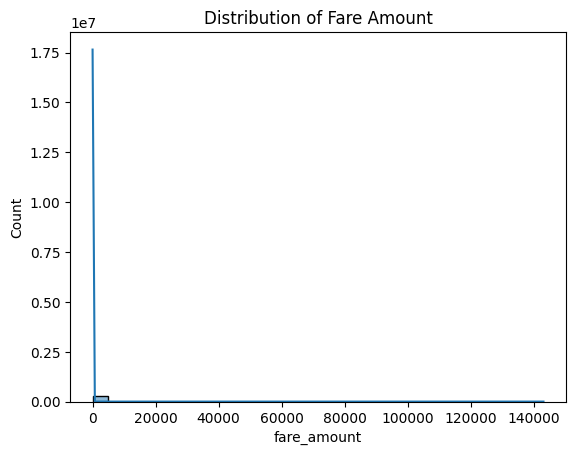

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2008-12-31 15:05:04   2008-12-31 16:18:04              1.0   
1         2  2008-12-31 20:41:22   2008-12-31 21:03:22              1.0   
2         2  2009-01-01 00:06:35   2009-01-01 02:22:53              5.0   
3         2  2009-01-01 07:07:04   2009-01-01 08:33:41              1.0   
4         2  2023-08-31 23:56:01   2023-09-01 00:18:41              1.0   

   trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0          11.77         1.0           230           138             1   
1           6.46         1.0           162           264             1   
2           4.48         1.0           161            74             1   
3           3.07         1.0           170           141             1   
4           3.11         1.0           114           246             1   

   fare_amount  ...  tip_amount  tolls_amount  improvement_surcharge  \
0         68.8  ...       16.45 

In [29]:
# Continue with outlier handling
# 1. Removing entries where trip_distance is nearly 0 and fare_amount is more than 300
df2 = df2[~((df2["trip_distance"] <= 0.1) & (df2["fare_amount"] > 300))]

# 2. Removing entries where trip_distance and fare_amount are 0 but pickup and dropoff zones are different
df2 = df2[~((df2["trip_distance"] == 0) & (df2["fare_amount"] == 0) & (df2["PULocationID"] != df2["DOLocationID"]))]

# 3. Removing entries where trip_distance is more than 250 miles
df2 = df2[df2["trip_distance"] <= 250]

# 4. Removing entries where payment_type is 0 (undefined payment type)
df2 = df2[df2["payment_type"] != 0]

# 5. Checking for other anomalies:
# - Removing negative values in fare_amount and trip_distance
df2 = df2[(df2["fare_amount"] >= 0) & (df2["trip_distance"] >= 0)]

# - Removing unrealistic passenger counts (e.g., more than 6)
df2 = df2[df2["passenger_count"] <= 6]

sns.histplot(df2['fare_amount'], kde=True, bins=30)
plt.title("Distribution of Fare Amount")
plt.show()
print(df2.head())
print(df2.tail())

In [30]:
# Do any columns need standardising?
# can be done, Checking for normal distribution
# Yes it can be standardised
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df2['fare_amount_scaled'] = scaler.fit_transform(df2[['fare_amount']])


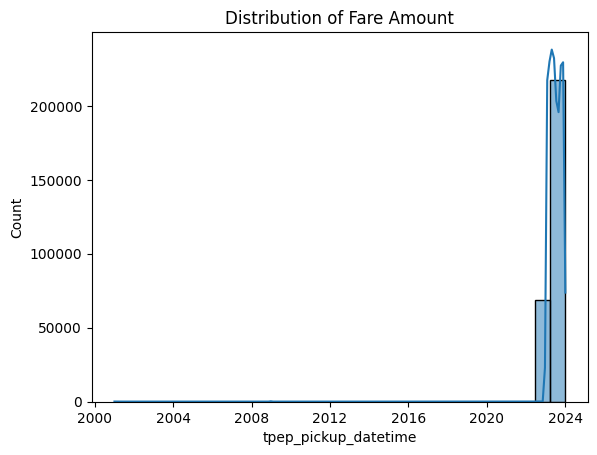

In [31]:
sns.histplot(df2['tpep_pickup_datetime'],kde=True,bins=30)
plt.title("Distribution of Fare Amount")
plt.show()

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [32]:
df2.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'date',
 'hour',
 'diffs',
 'Airport_fee_combined',
 'total_amount_negative',
 'fare_amount_scaled']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

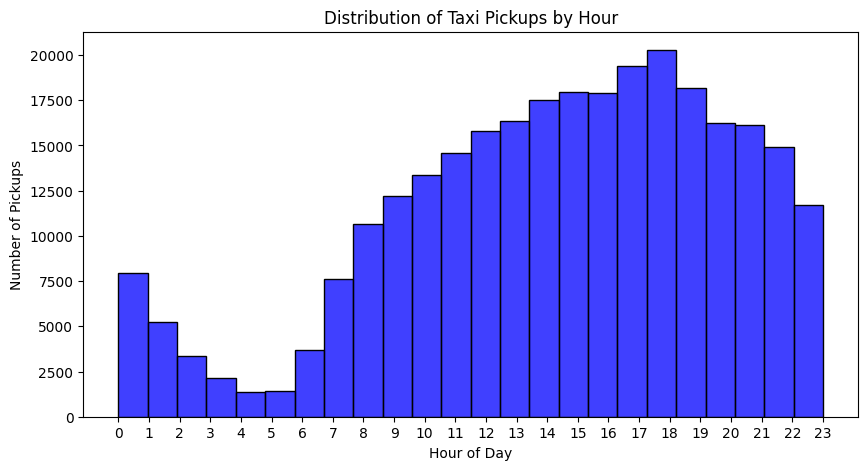

In [33]:
# Find and show the hourly trends in taxi pickups
df2.head()
# Convert pickup_datetime to datetime format
df2['tpep_pickup_datetime'] = pd.to_datetime(df2['tpep_pickup_datetime'])

# Extract hour, day of the week, and month
df2['pickup_hour'] = df2['tpep_pickup_datetime'].dt.hour
df2['pickup_day'] = df2['tpep_pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df2['pickup_month'] = df2['tpep_pickup_datetime'].dt.month
plt.figure(figsize=(10, 5))
sns.histplot(df2['pickup_hour'], bins=24, kde=False, color='blue')
plt.xticks(range(24))
plt.xlabel("Hour of Day")
plt.ylabel("Number of Pickups")
plt.title("Distribution of Taxi Pickups by Hour")
plt.show()

<Axes: xlabel='pickup_day', ylabel='Count'>

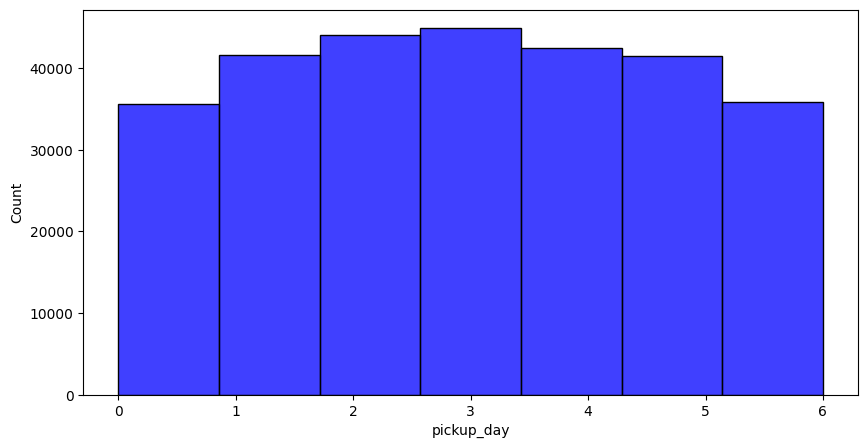

In [34]:
# Find and show the daily trends in taxi pickups (days of the week)
plt.figure(figsize=(10, 5))
sns.histplot(df2['pickup_day'], bins=7, kde=False, color='blue')

<Axes: xlabel='pickup_month', ylabel='Count'>

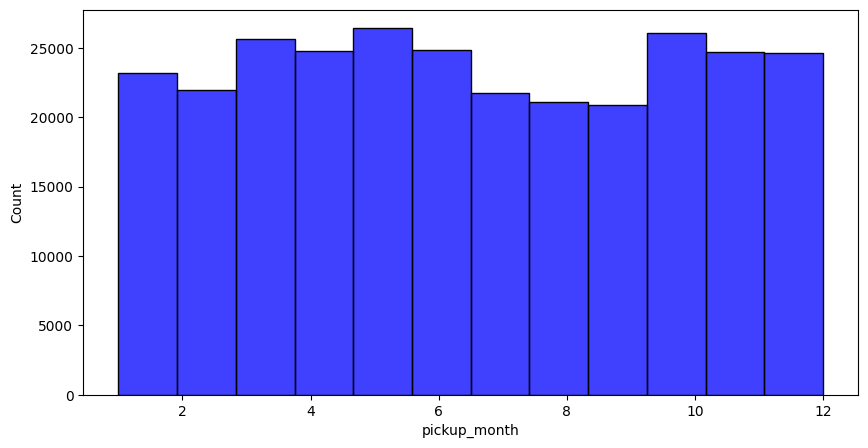

In [35]:
# Show the monthly trends in pickups
plt.figure(figsize=(10, 5))
sns.histplot(df2['pickup_month'], bins=12, kde=False, color='blue')

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [36]:
# Analyse the above parameters

# Columns to check
columns_to_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

# Check for zero and negative values
for col in columns_to_check:
    zero_values = (df2[col] == 0).sum()
    negative_values = (df2[col] < 0).sum()

    print(f"Column: {col}")
    print(f" - Zero values: {zero_values}")
    print(f" - Negative values: {negative_values}\n")


Column: fare_amount
 - Zero values: 93
 - Negative values: 0

Column: tip_amount
 - Zero values: 63871
 - Negative values: 0

Column: total_amount
 - Zero values: 34
 - Negative values: 0

Column: trip_distance
 - Zero values: 3523
 - Negative values: 0



In [37]:
# Create a full copy of df2
df3 = df2.copy()

# Create a filtered copy excluding zero or negative values
df3_nonzero = df3[(df3['fare_amount'] > 0) &
                  (df3['tip_amount'] >= 0) &
                  (df3['total_amount'] > 0) &
                  (df3['trip_distance'] > 0)].copy()

# Print shapes for comparison
print("Original DataFrame (df3) shape:", df3.shape)
print("Filtered DataFrame (df3_nonzero) shape:", df3_nonzero.shape)


Original DataFrame (df3) shape: (285963, 26)
Filtered DataFrame (df3_nonzero) shape: (282384, 26)


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [38]:
# Create a df with non zero entries for the selected parameters.
# Create a full copy of df2
df3 = df2.copy()

# Create a filtered copy excluding zero or negative values
df3_nonzero = df3[(df3['fare_amount'] > 0) &
                  (df3['tip_amount'] >= 0) &
                  (df3['total_amount'] > 0) &
                  (df3['trip_distance'] > 0)].copy()

# Print shapes for comparison
print("Original DataFrame (df3) shape:", df3.shape)
print("Filtered DataFrame (df3_nonzero) shape:", df3_nonzero.shape)


Original DataFrame (df3) shape: (285963, 26)
Filtered DataFrame (df3_nonzero) shape: (282384, 26)


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

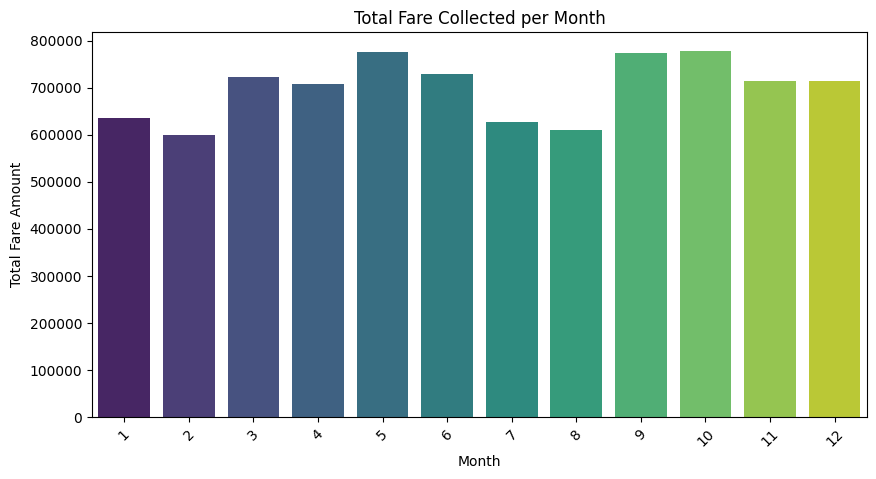

In [80]:
# Group data by month and analyse monthly revenue

df3.groupby('pickup_month')['total_amount'].sum()

# Grouping total_amount by pickup_month
monthly_revenue = df3.groupby('pickup_month')['total_amount'].sum().reset_index()

# Plotting the monthly total fare amount
plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_revenue, x='pickup_month', y='total_amount', palette='viridis')

# Formatting the plot
plt.xlabel("Month")
plt.ylabel("Total Fare Amount")
plt.title("Total Fare Collected per Month")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

quarter
1    0.233443
2    0.263756
3    0.239722
4    0.263079
Name: total_amount, dtype: float64


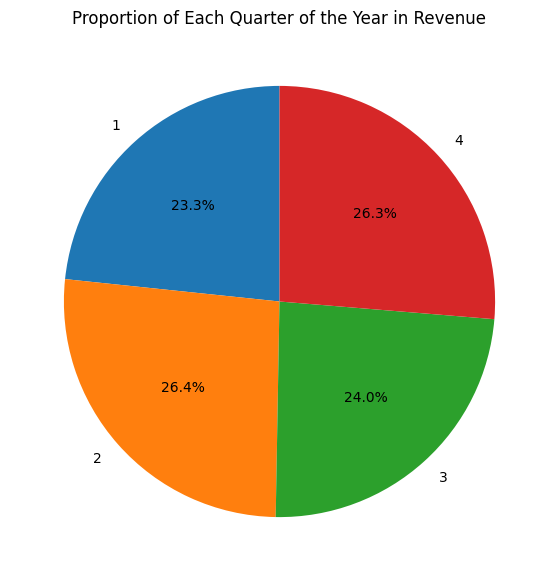

In [40]:
# Calculate proportion of each quarter

df3['tpep_pickup_datetime'] = pd.to_datetime(df3['tpep_pickup_datetime'])

df3['quarter'] = df3['tpep_pickup_datetime'].dt.quarter
quarter_revenue = df3.groupby('quarter')['total_amount'].sum()
quarter_proportion = quarter_revenue / quarter_revenue.sum()
print(quarter_proportion)

plt.figure(figsize=(7,7))
plt.pie(quarter_proportion, labels=quarter_proportion.index, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Each Quarter of the Year in Revenue')
plt.show()


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

Correlation between trip_distance and fare_amount: 0.06


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'date', 'hour', 'diffs', 'Airport_fee_combined',
       'total_amount_negative', 'fare_amount_scaled', 'pickup_hour',
       'pickup_day', 'pickup_month', 'quarter'],
      dtype='object')

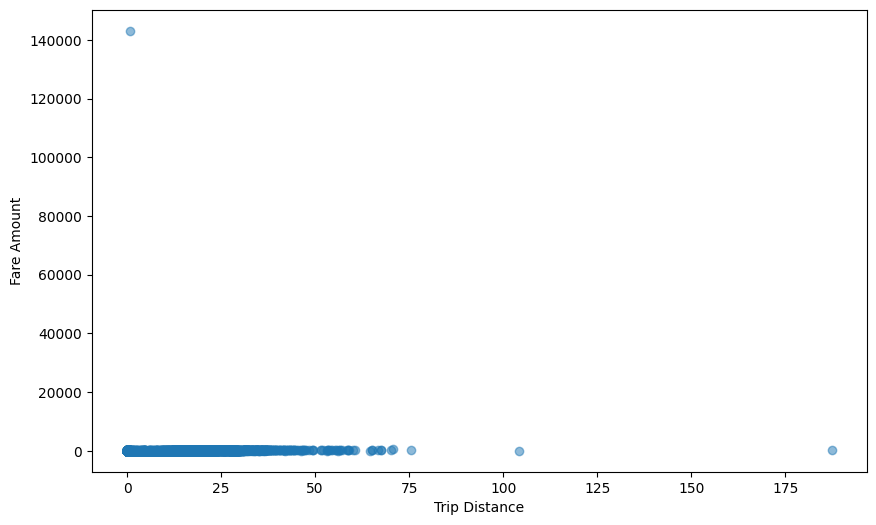

In [41]:
# Show how trip fare is affected by distance

df_filtered = df3[df3['trip_distance']>0]

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['trip_distance'], df_filtered['fare_amount'], alpha=0.5)
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')

correlation = df_filtered[['trip_distance', 'fare_amount']].corr().iloc[0,1]
print(f'Correlation between trip_distance and fare_amount: {correlation:.2f}')


df_filtered.columns

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [42]:
# Show relationship between fare and trip duration
df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])
df_filtered['tpep_dropoff_datetime'] = pd.to_datetime(df_filtered['tpep_dropoff_datetime'])

print(f'Correlation between trip_distance and fare_amount: {correlation:.2f}')
# Compute correlation values
correlation_fare_passenger = df_filtered[['fare_amount', 'passenger_count']].corr().iloc[0,1]
correlation_tip_distance = df_filtered[['tip_amount', 'trip_distance']].corr().iloc[0,1]

# Print the results
print(f'Correlation between fare_amount and passenger_count: {correlation_fare_passenger:.2f}')
print(f'Correlation between tip_amount and trip_distance: {correlation_tip_distance:.2f}')



Correlation between trip_distance and fare_amount: 0.06
Correlation between fare_amount and passenger_count: 0.00
Correlation between tip_amount and trip_distance: 0.59


In [43]:
# Show relationship between fare and number of passengers
correlation_fare_passenger = df_filtered[['fare_amount', 'passenger_count']].corr().iloc[0,1]
print(f'Correlation between fare_amount and passenger_count: {correlation_fare_passenger:.2f}')


Correlation between fare_amount and passenger_count: 0.00


In [44]:
# Show relationship between tip and trip distance
correlation_tip_distance = df_filtered[['tip_amount', 'trip_distance']].corr().iloc[0,1]
print(f'Correlation between tip_amount and trip_distance: {correlation_tip_distance:.2f}')


Correlation between tip_amount and trip_distance: 0.59


In [81]:
# Show relationship between tip and fare_amount
correlation_tip_distance = df_filtered[['tip_amount', 'fare_amount']].corr().iloc[0,1]
print(f'Correlation between tip_amount and fare_amount: {correlation_tip_distance:.2f}')


Correlation between tip_amount and fare_amount: 0.04


In [83]:
# Show relationship between trips and passenger
correlation_tip_distance = df_filtered[['trip_distance', 'passenger_count']].corr().iloc[0,1]
print(f'Correlation between trip_distance and passenger_count: {correlation_tip_distance:.2f}')


Correlation between trip_distance and passenger_count: 0.04


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

In [45]:
# Analyse the distribution of different payment types (payment_type).

df3['payment_type'].value_counts()



payment_type
1    232984
2     49507
4      2124
3      1348
Name: count, dtype: int64

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [46]:
!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [47]:
import geopandas as gpd


# Read the shapefile using geopandas
zones = gpd.read_file('/content/drive/MyDrive/NYC_Taxi_analysis/taxi_zones.shp')
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


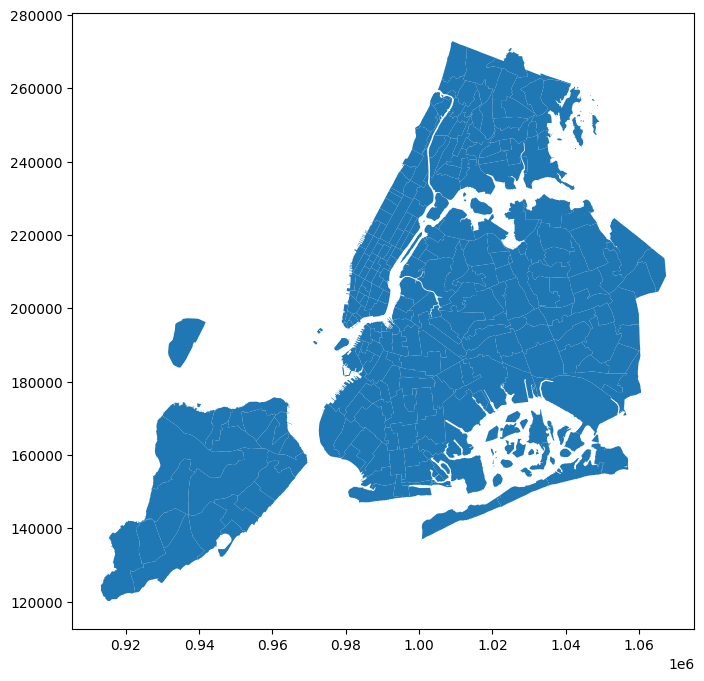

In [48]:
print(zones.info())
zones.plot(figsize=(10, 8))
plt.show()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [49]:
df_filtered.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2008-12-31 15:05:04   2008-12-31 16:18:04              1.0   
1         2  2008-12-31 20:41:22   2008-12-31 21:03:22              1.0   
2         2  2009-01-01 00:06:35   2009-01-01 02:22:53              5.0   
3         2  2009-01-01 07:07:04   2009-01-01 08:33:41              1.0   
4         2  2023-08-31 23:56:01   2023-09-01 00:18:41              1.0   

   trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0          11.77         1.0           230           138             1   
1           6.46         1.0           162           264             1   
2           4.48         1.0           161            74             1   
3           3.07         1.0           170           141             1   
4           3.11         1.0           114           246             1   

   fare_amount  ...        date  hour  diffs  Airport_fee_combined  \
0         68.8  ...  2008-12-31    15  False                   0.0   
1         28.9  ...  2008-12-31    20  False                   0.0   
2         21.2  ...  2009-01-01     0  False                   0.0   
3         20.5  ...  2009-01-01     7  False                   0.0   
4         21.2  ...  2023-08-31    23  False                   0.0   

   total_amount_negative  fare_amount_scaled  pickup_hour pickup_day  \
0                  False            0.181113           15          2   
1                  False            0.032395           20          2   
2                  False            0.003695            0          3   
3                  False            0.001086            7          3   
4                  False            0.003695           23          3   

   pickup_month  quarter  
0            12        4  
1            12        4  
2             1        1  
3             1        1  
4             8        3  

[5 rows x 27 columns]

In [50]:
# Merge zones and trip records using locationID and PULocationID
df_merged = pd.merge(df_filtered, zones, left_on='PULocationID', right_on='LocationID', how='left')

# Display first few rows after merging
df_merged.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2008-12-31 15:05:04   2008-12-31 16:18:04              1.0   
1         2  2008-12-31 20:41:22   2008-12-31 21:03:22              1.0   
2         2  2009-01-01 00:06:35   2009-01-01 02:22:53              5.0   
3         2  2009-01-01 07:07:04   2009-01-01 08:33:41              1.0   
4         2  2023-08-31 23:56:01   2023-09-01 00:18:41              1.0   

   trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0          11.77         1.0           230           138             1   
1           6.46         1.0           162           264             1   
2           4.48         1.0           161            74             1   
3           3.07         1.0           170           141             1   
4           3.11         1.0           114           246             1   

   fare_amount  ...  pickup_day  pickup_month  quarter  OBJECTID  Shape_Leng  \
0         68.8  ...           2            12        4     230.0    0.031028   
1         28.9  ...           2            12        4     162.0    0.035270   
2         21.2  ...           3             1        1     161.0    0.035804   
3         20.5  ...           3             1        1     170.0    0.045769   
4         21.2  ...           3             8        3     114.0    0.031727   

   Shape_Area                       zone LocationID    borough  \
0    0.000056  Times Sq/Theatre District      230.0  Manhattan   
1    0.000048               Midtown East      162.0  Manhattan   
2    0.000072             Midtown Center      161.0  Manhattan   
3    0.000074                Murray Hill      170.0  Manhattan   
4    0.000047    Greenwich Village South      114.0  Manhattan   

                                            geometry  
0  POLYGON ((988786.877 214532.094, 988650.277 21...  
1  POLYGON ((992224.354 214415.293, 992096.999 21...  
2  POLYGON ((991081.026 214453.698, 990952.644 21...  
3  POLYGON ((991999.299 210994.739, 991972.635 21...  
4  POLYGON ((986306.712 203122.786, 986300.242 20...  

[5 rows x 34 columns]

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [51]:
# Group data by location and calculate the number of trips
# Group by LocationID and count trips
grouped_data = df_merged.groupby('LocationID').size().reset_index(name='total_trips')

# Display top locations with most trips
grouped_data.sort_values(by='total_trips', ascending=False).head()

LocationID  total_trips
115       132.0        14758
211       237.0        13489
143       161.0        13327
210       236.0        12047
144       162.0        10315

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [52]:
# Merge trip counts back to the zones GeoDataFrame
zones = zones.merge(grouped_data, on='LocationID', how='left')

# Fill NaN values (zones with no trips) with 0
zones['total_trips'] = zones['total_trips'].fillna(0)

# Display the updated zones dataframe
zones.sort_values(by='total_trips', ascending=False).head()

OBJECTID  Shape_Leng  Shape_Area                   zone  LocationID  \
131       132    0.245479    0.002038            JFK Airport         132   
236       237    0.042213    0.000096  Upper East Side South         237   
160       161    0.035804    0.000072         Midtown Center         161   
235       236    0.044252    0.000103  Upper East Side North         236   
161       162    0.035270    0.000048           Midtown East         162   

       borough                                           geometry  total_trips  
131     Queens  MULTIPOLYGON (((1032791.001 181085.006, 103283...      14758.0  
236  Manhattan  POLYGON ((993633.442 216961.016, 993507.232 21...      13489.0  
160  Manhattan  POLYGON ((991081.026 214453.698, 990952.644 21...      13327.0  
235  Manhattan  POLYGON ((995940.048 221122.92, 995812.322 220...      12047.0  
161  Manhattan  POLYGON ((992224.354 214415.293, 992096.999 21...      10315.0

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

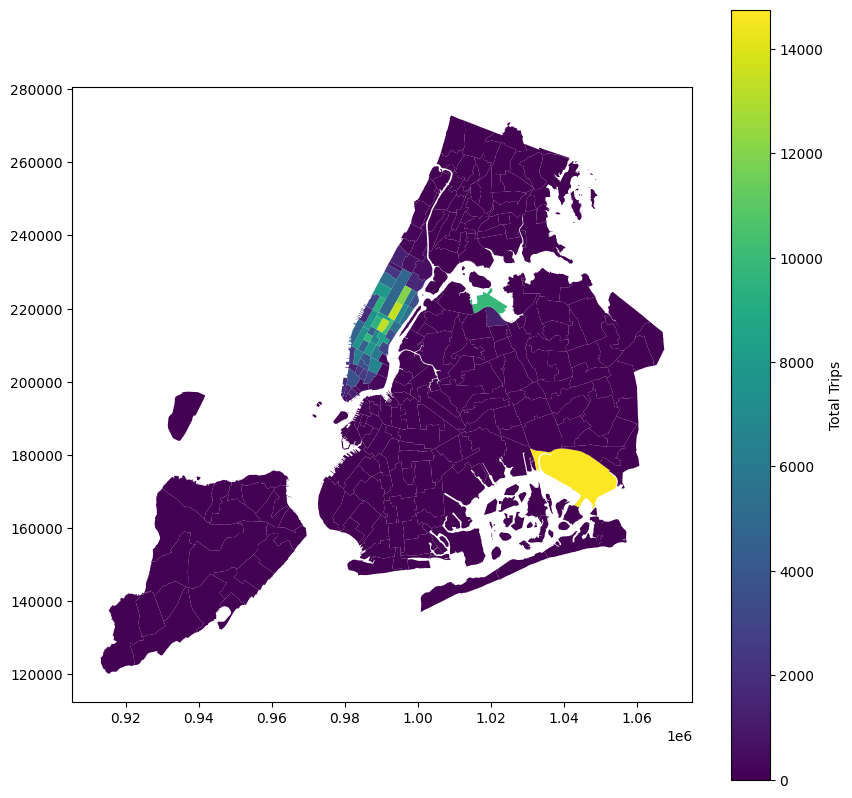

In [53]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the map with a color-coded scheme
zones.plot(column='total_trips', ax=ax, legend=True, legend_kwds={'label': "Total Trips", 'orientation': "vertical"})

# Show the plot
plt.show()

# Plot the map and display it


In [54]:
# can you try displaying the zones DF sorted by the number of trips?


# Fill NaN values (zones with no trips) with 0
zones['total_trips'] = zones['total_trips'].fillna(0)

# Display the updated zones dataframe
zones.sort_values(by='total_trips', ascending=False).head()


OBJECTID  Shape_Leng  Shape_Area                   zone  LocationID  \
131       132    0.245479    0.002038            JFK Airport         132   
236       237    0.042213    0.000096  Upper East Side South         237   
160       161    0.035804    0.000072         Midtown Center         161   
235       236    0.044252    0.000103  Upper East Side North         236   
161       162    0.035270    0.000048           Midtown East         162   

       borough                                           geometry  total_trips  
131     Queens  MULTIPOLYGON (((1032791.001 181085.006, 103283...      14758.0  
236  Manhattan  POLYGON ((993633.442 216961.016, 993507.232 21...      13489.0  
160  Manhattan  POLYGON ((991081.026 214453.698, 990952.644 21...      13327.0  
235  Manhattan  POLYGON ((995940.048 221122.92, 995812.322 220...      12047.0  
161  Manhattan  POLYGON ((992224.354 214415.293, 992096.999 21...      10315.0

In [85]:

# Group the data by PULocationID to count total trips per zone
trip_counts = df_filtered.groupby('PULocationID').size().reset_index(name='total_trips')

# Merge the trip counts into the zones GeoDataFrame
zones = zones.merge(trip_counts, left_on='LocationID', right_on='PULocationID', how='left')


# Display the updated zones dataframe
zones.sort_values(by='total_trips', ascending=False).head()


OBJECTID  Shape_Leng  Shape_Area                   zone  LocationID  \
131       132    0.245479    0.002038            JFK Airport         132   
236       237    0.042213    0.000096  Upper East Side South         237   
160       161    0.035804    0.000072         Midtown Center         161   
235       236    0.044252    0.000103  Upper East Side North         236   
161       162    0.035270    0.000048           Midtown East         162   

       borough                                           geometry  \
131     Queens  MULTIPOLYGON (((1032791.001 181085.006, 103283...   
236  Manhattan  POLYGON ((993633.442 216961.016, 993507.232 21...   
160  Manhattan  POLYGON ((991081.026 214453.698, 990952.644 21...   
235  Manhattan  POLYGON ((995940.048 221122.92, 995812.322 220...   
161  Manhattan  POLYGON ((992224.354 214415.293, 992096.999 21...   

     total_trips_x  PULocationID_x  total_trips_y  PULocationID_y  total_trips  
131        14758.0           132.0        14757.0           132.0      14757.0  
236        13489.0           237.0        13486.0           237.0      13486.0  
160        13327.0           161.0        13327.0           161.0      13327.0  
235        12047.0           236.0        12046.0           236.0      12046.0  
161        10315.0           162.0        10314.0           162.0      10314.0

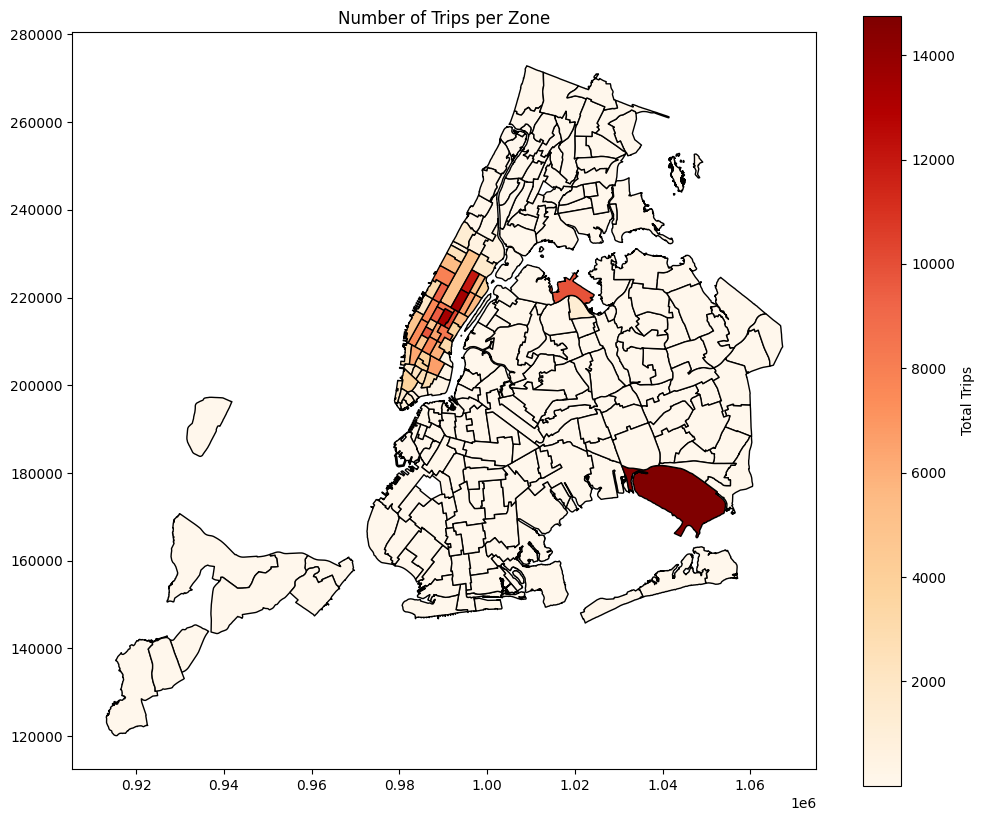

In [86]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the map with a color-coded scheme
zones.plot(column='total_trips', ax=ax, legend=True,
           legend_kwds={'label': "Total Trips", 'orientation': "vertical"},
           cmap="OrRd", edgecolor="black")

# Add title
plt.title("Number of Trips per Zone")

# Show the plot
plt.show()

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

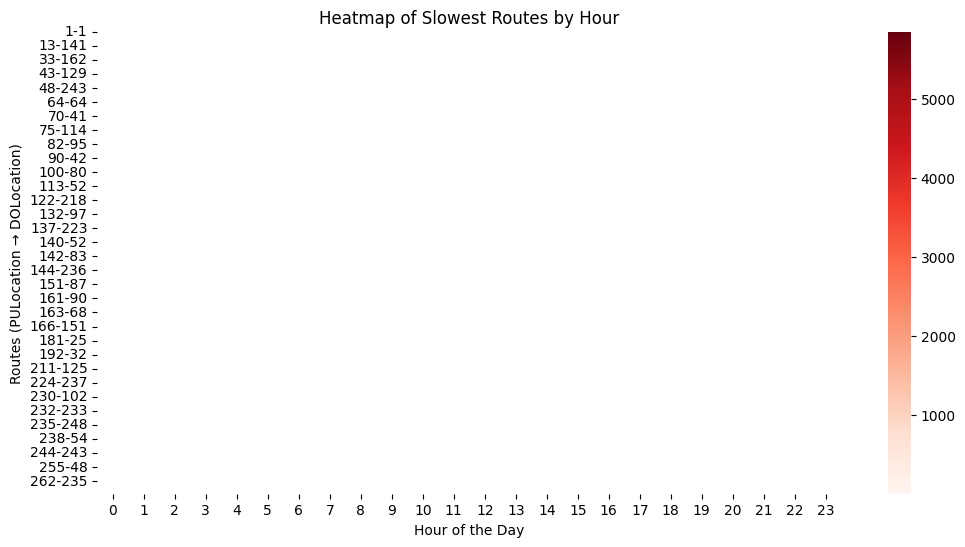

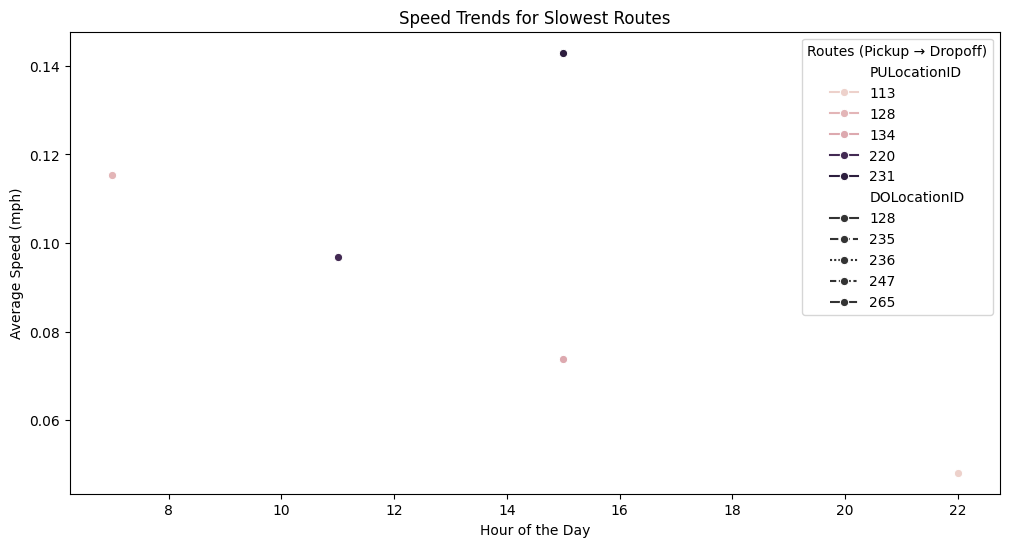

In [90]:
# Find routes which have the slowest speeds at different times of the day
df_filtered.head()
df_filtered.columns

df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])
df_filtered['tpep_dropoff_datetime'] = pd.to_datetime(df_filtered['tpep_dropoff_datetime'])

df_filtered['trip_duration_hours'] = (df_filtered['tpep_dropoff_datetime'] - df_filtered['tpep_pickup_datetime']).dt.total_seconds() / 3600

# Avoid division errors (remove trips with 0 duration)
df_filtered = df_filtered[df_filtered['trip_duration_hours'] > 0]

# Calculate speed (distance / duration)
df_filtered['speed'] = df_filtered['trip_distance'] / df_filtered['trip_duration_hours']

# Group by route (PULocationID → DOLocationID) and hour
slow_routes = df_filtered.groupby(['PULocationID', 'DOLocationID', 'hour']).agg(
    avg_speed=('speed', 'mean'),
    avg_distance=('trip_distance', 'mean'),
    avg_duration=('trip_duration_hours', 'mean'),
    trip_count=('PULocationID', 'count')
).reset_index()

# Sort by average speed (ascending) to get the slowest routes
slow_routes = slow_routes.sort_values(by='avg_speed', ascending=True)

# Display top slow routes
slow_routes.head(10)

slow_routes_pivot = slow_routes.pivot_table(index=['PULocationID', 'DOLocationID'], columns='hour', values='avg_speed')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(slow_routes_pivot, cmap="Reds", linewidths=0.5)
plt.title("Heatmap of Slowest Routes by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Routes (PULocation → DOLocation)")
plt.show()

# Select the slowest 5 routes
top_slow_routes = slow_routes.groupby(['PULocationID', 'DOLocationID']).mean().nsmallest(5, 'avg_speed').reset_index()

# Filter data for these routes
slow_routes_filtered = slow_routes[
    slow_routes[['PULocationID', 'DOLocationID']].apply(tuple, axis=1).isin(
        top_slow_routes[['PULocationID', 'DOLocationID']].apply(tuple, axis=1)
    )
]

# Plot speed trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=slow_routes_filtered, x='hour', y='avg_speed', hue='PULocationID', style='DOLocationID', marker='o')
plt.title("Speed Trends for Slowest Routes")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Speed (mph)")
plt.legend(title="Routes (Pickup → Dropoff)")
plt.show()


How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

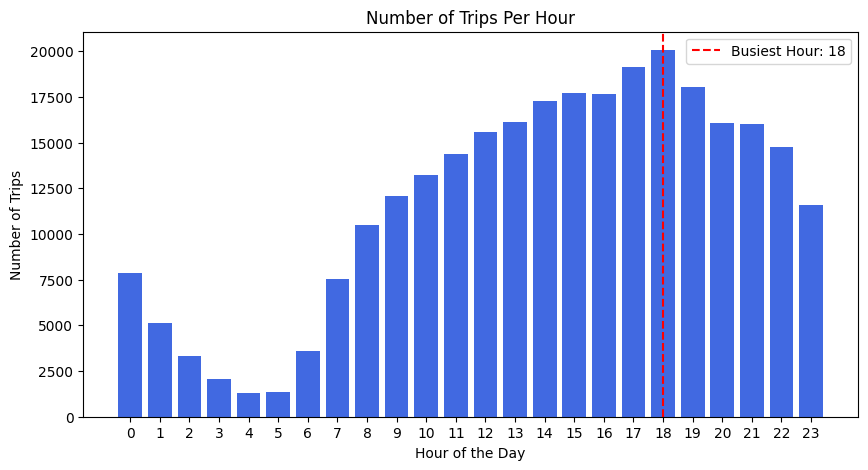

Busiest Hour: 18 with 20061 trips


In [56]:
# Visualise the number of trips per hour and find the busiest hour

# Ensure datetime conversion
df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])

# Extract the pickup hour
df_filtered['pickup_hour'] = df_filtered['tpep_pickup_datetime'].dt.hour

# Count number of trips per hour
hourly_trips = df_filtered.groupby('pickup_hour').size().reset_index(name='total_trips')

# Find the busiest hour
busiest_hour = hourly_trips.loc[hourly_trips['total_trips'].idxmax()]

# Plot the trips per hour
plt.figure(figsize=(10,5))
plt.bar(hourly_trips['pickup_hour'], hourly_trips['total_trips'], color='royalblue')
plt.axvline(x=busiest_hour['pickup_hour'], color='red', linestyle='--', label=f'Busiest Hour: {busiest_hour["pickup_hour"]}')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips Per Hour')
plt.xticks(range(24))
plt.legend()
plt.show()

# Display busiest hour details
print(f"Busiest Hour: {busiest_hour['pickup_hour']} with {busiest_hour['total_trips']} trips")

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [57]:
# Scale up the number of trips
sampling_fraction = 0.5
# Fill in the value of your sampling fraction and use that to scale up the numbers
top_5_busiest_hours = hourly_trips.sort_values(by='total_trips', ascending=False).head(5)
# Count trips per hour

# Find the top 5 busiest hours

# Scale up the trip counts
top_5_busiest_hours['scaled_trips'] = (top_5_busiest_hours['total_trips'] / sampling_fraction).astype(int)

# Display the results
print(top_5_busiest_hours)



    pickup_hour  total_trips  scaled_trips
18           18        20061         40122
17           17        19153         38306
19           19        18014         36028
15           15        17709         35418
16           16        17679         35358


**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

   pickup_hour  total_trips_weekday  total_trips_weekend
0            0                 3888                 3952
1            1                 1890                 3258
2            2                  960                 2365
3            3                  548                 1542
4            4                  518                  767


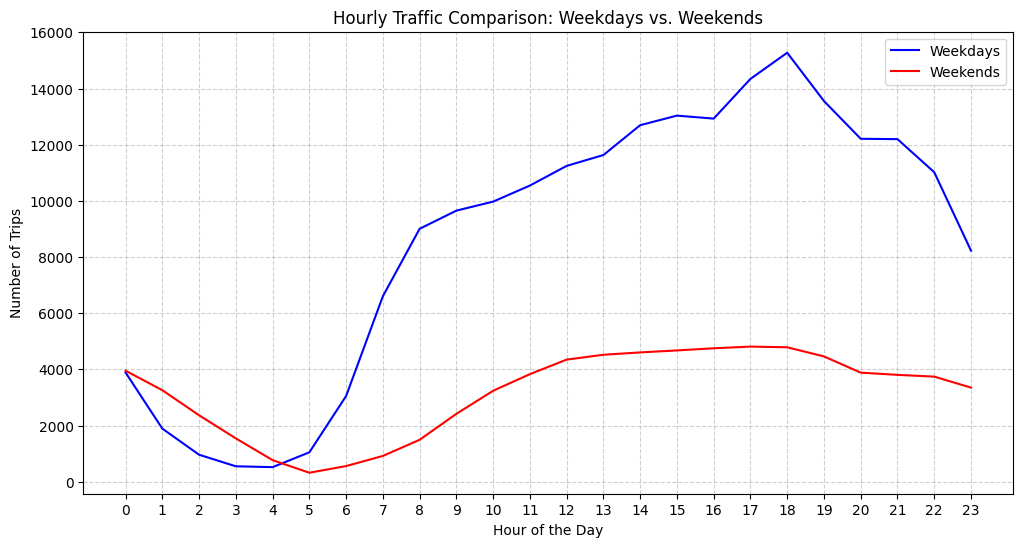

In [58]:
# Compare traffic trends for the week days and weekends
# Ensure datetime conversion
df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])

# Extract weekday (0 = Monday, 6 = Sunday) and hour
df_filtered['weekday'] = df_filtered['tpep_pickup_datetime'].dt.weekday
df_filtered['pickup_hour'] = df_filtered['tpep_pickup_datetime'].dt.hour

# Split data into weekdays and weekends
df_weekdays = df_filtered[df_filtered['weekday'] < 5]  # Monday to Friday
df_weekends = df_filtered[df_filtered['weekday'] >= 5]  # Saturday and Sunday


# Count trips per hour for weekdays and weekends
weekday_hourly_trips = df_weekdays.groupby('pickup_hour').size().reset_index(name='total_trips')
weekend_hourly_trips = df_weekends.groupby('pickup_hour').size().reset_index(name='total_trips')

# Merge for direct comparison
hourly_comparison = weekday_hourly_trips.merge(weekend_hourly_trips, on='pickup_hour', suffixes=('_weekday', '_weekend'))

# Display first few rows
print(hourly_comparison.head())

plt.figure(figsize=(12, 6))

# Plot weekday traffic
plt.plot(hourly_comparison['pickup_hour'], hourly_comparison['total_trips_weekday'], label='Weekdays', color='blue')

# Plot weekend traffic
plt.plot(hourly_comparison['pickup_hour'], hourly_comparison['total_trips_weekend'], label='Weekends', color='red')

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Hourly Traffic Comparison: Weekdays vs. Weekends')
plt.xticks(range(24))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

Top 10 Pickup Zones:
Index(['JFK Airport', 'Upper East Side South', 'Midtown Center',
       'Upper East Side North', 'Midtown East', 'LaGuardia Airport',
       'Penn Station/Madison Sq West', 'Times Sq/Theatre District',
       'Lincoln Square East', 'Murray Hill'],
      dtype='object', name='zone')

Top 10 Dropoff Zones:
Index(['Upper East Side North', 'Upper East Side South', 'Midtown Center',
       'Times Sq/Theatre District', 'Murray Hill', 'Midtown East',
       'Lincoln Square East', 'Upper West Side South', 'Lenox Hill West',
       'East Chelsea'],
      dtype='object', name='zone')


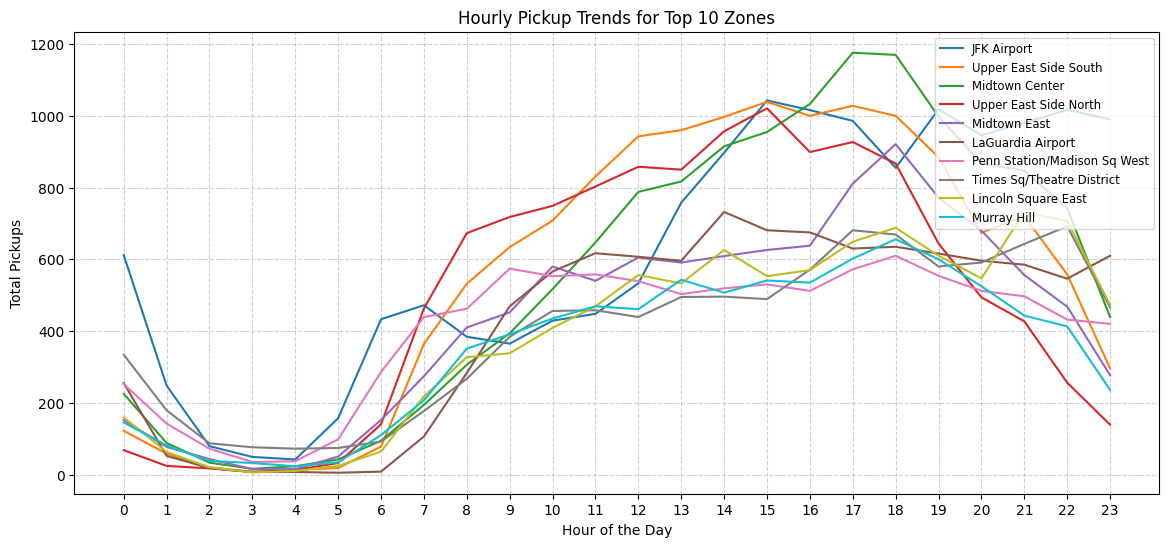

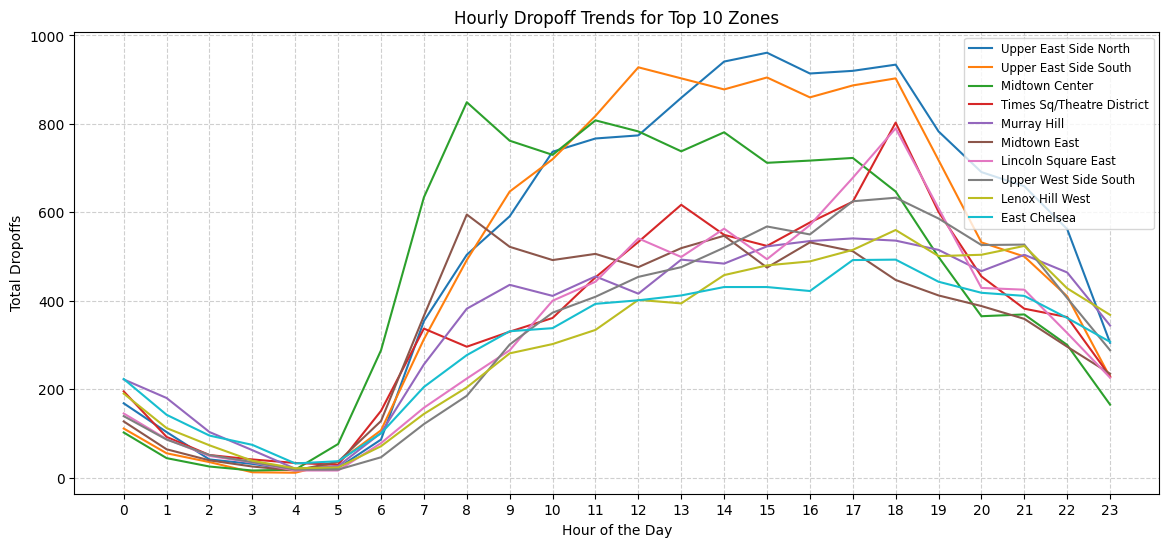

In [59]:
# Find top 10 pickup and dropoff zones

# Merge trip data with zone data for pickups
df_pickups = df_filtered.merge(zones, left_on='PULocationID', right_on='LocationID', how='left')

# Merge trip data with zone data for drop-offs
df_dropoffs = df_filtered.merge(zones, left_on='DOLocationID', right_on='LocationID', how='left')

# Group by pickup zone and hour
pickup_counts = df_pickups.groupby(['zone', 'pickup_hour']).size().reset_index(name='total_pickups')

# Group by dropoff zone and hour
dropoff_counts = df_dropoffs.groupby(['zone', 'pickup_hour']).size().reset_index(name='total_dropoffs')

# Find top 10 zones with highest total pickups
top_10_pickup_zones = pickup_counts.groupby('zone')['total_pickups'].sum().nlargest(10).index

# Find top 10 zones with highest total dropoffs
top_10_dropoff_zones = dropoff_counts.groupby('zone')['total_dropoffs'].sum().nlargest(10).index

# Filter data for only the top 10 zones
pickup_counts_top10 = pickup_counts[pickup_counts['zone'].isin(top_10_pickup_zones)]
dropoff_counts_top10 = dropoff_counts[dropoff_counts['zone'].isin(top_10_dropoff_zones)]

# Display top pickup and dropoff zones
print("Top 10 Pickup Zones:")
print(top_10_pickup_zones)

print("\nTop 10 Dropoff Zones:")
print(top_10_dropoff_zones)


# Plot hourly trends for top pickup zones
plt.figure(figsize=(14, 6))
for zone in top_10_pickup_zones:
    zone_data = pickup_counts_top10[pickup_counts_top10['zone'] == zone]
    plt.plot(zone_data['pickup_hour'], zone_data['total_pickups'], label=zone)

plt.xlabel('Hour of the Day')
plt.ylabel('Total Pickups')
plt.title('Hourly Pickup Trends for Top 10 Zones')
plt.xticks(range(24))
plt.legend(loc='upper right', fontsize='small')
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Plot hourly trends for top dropoff zones
plt.figure(figsize=(14, 6))
for zone in top_10_dropoff_zones:
    zone_data = dropoff_counts_top10[dropoff_counts_top10['zone'] == zone]
    plt.plot(zone_data['pickup_hour'], zone_data['total_dropoffs'], label=zone)

plt.xlabel('Hour of the Day')
plt.ylabel('Total Dropoffs')
plt.title('Hourly Dropoff Trends for Top 10 Zones')
plt.xticks(range(24))
plt.legend(loc='upper right', fontsize='small')
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [60]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
# Count total pickups per zone
pickup_totals = df_filtered.groupby('PULocationID').size().reset_index(name='total_pickups')

# Count total dropoffs per zone
dropoff_totals = df_filtered.groupby('DOLocationID').size().reset_index(name='total_dropoffs')

# Rename columns for merging
pickup_totals.rename(columns={'PULocationID': 'LocationID'}, inplace=True)
dropoff_totals.rename(columns={'DOLocationID': 'LocationID'}, inplace=True)

# Merge pickup and dropoff data
zone_totals = pd.merge(pickup_totals, dropoff_totals, on='LocationID', how='outer').fillna(0)

# Merge with zone names
zone_totals = pd.merge(zone_totals, zones[['LocationID', 'zone']], on='LocationID', how='left')

# Compute pickup/dropoff ratio
zone_totals['pickup_dropoff_ratio'] = zone_totals['total_pickups'] / (zone_totals['total_dropoffs'] + 1e-6)  # Avoid division by zero

# Display first few rows
zone_totals.head()

# Get the top 10 highest pickup/dropoff ratio zones
highest_ratio_zones = zone_totals.nlargest(10, 'pickup_dropoff_ratio')

# Get the top 10 lowest pickup/dropoff ratio zones
lowest_ratio_zones = zone_totals.nsmallest(10, 'pickup_dropoff_ratio')

# Display results
print(highest_ratio_zones[['zone', 'total_pickups', 'total_dropoffs', 'pickup_dropoff_ratio']])

print(lowest_ratio_zones[['zone', 'total_pickups', 'total_dropoffs', 'pickup_dropoff_ratio']])


                             zone  total_pickups  total_dropoffs  \
69                  East Elmhurst         1290.0             141   
125                   JFK Airport        14757.0            2950   
131             LaGuardia Airport         9902.0            3332   
178  Penn Station/Madison Sq West         9708.0            6344   
41                   Central Park         4852.0            3513   
239                  West Village         6307.0            4631   
108       Greenwich Village South         3658.0            2747   
155                  Midtown East        10314.0            8114   
154                Midtown Center        13327.0           11151   
98               Garment District         4603.0            3890   

     pickup_dropoff_ratio  
69               9.148936  
125              5.002373  
131              2.971789  
178              1.530265  
41               1.381156  
239              1.361909  
108              1.331635  
155              1.271136  

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [61]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])

df_filtered['pickup_hour'] = df_filtered['tpep_pickup_datetime'].dt.hour

night_trips = df_filtered[(df_filtered['pickup_hour'] >= 23) | (df_filtered['pickup_hour'] <= 5)]

night_pickups = night_trips.groupby('PULocationID').size().reset_index(name='total_pickups')

night_dropoffs = night_trips.groupby('DOLocationID').size().reset_index(name='total_dropoffs')

night_pickups.rename(columns={'PULocationID': 'LocationID'}, inplace=True)
night_dropoffs.rename(columns={'DOLocationID': 'LocationID'}, inplace=True)

night_pickups = night_pickups.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')
night_dropoffs = night_dropoffs.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

top_night_pickup_zones = night_pickups.nlargest(10, 'total_pickups')
top_night_dropoff_zones = night_dropoffs.nlargest(10, 'total_dropoffs')

# Note that the top zones should be of night hours and not the overall top zones
print(top_night_pickup_zones[['zone', 'total_pickups']])
print(top_night_dropoff_zones[['zone', 'total_dropoffs']])


                             zone  total_pickups
48                   East Village           2405
80                    JFK Airport           2177
160                  West Village           1937
27                   Clinton East           1535
94                Lower East Side           1494
69        Greenwich Village South           1300
144     Times Sq/Theatre District           1288
118  Penn Station/Madison Sq West           1056
85              LaGuardia Airport            954
106                 Midtown South            918
                      zone  total_dropoffs
74            East Village            1292
44            Clinton East            1060
155            Murray Hill             957
63            East Chelsea             910
97                Gramercy             900
128        Lenox Hill West             825
238         Yorkville West             781
224           West Village             721
212  Upper East Side North             687
84                Flatiron     

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [62]:
# Filter for night hours (11 PM to 5 AM)
# Ensure datetime conversion
df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])

# Extract pickup hour
df_filtered['pickup_hour'] = df_filtered['tpep_pickup_datetime'].dt.hour

# Categorize trips into nighttime (11PM-5AM) and daytime (5AM-11PM)
df_filtered['time_period'] = df_filtered['pickup_hour'].apply(lambda x: 'Nighttime' if (x >= 23 or x < 5) else 'Daytime')

# Calculate total revenue for each period
revenue_share = df_filtered.groupby('time_period')['total_amount'].sum().reset_index()

# Calculate percentage revenue share
total_revenue = revenue_share['total_amount'].sum()
revenue_share['revenue_percentage'] = (revenue_share['total_amount'] / total_revenue) * 100

# Display results
print(revenue_share)


  time_period  total_amount  revenue_percentage
0     Daytime    7352328.33           89.070928
1   Nighttime     902136.40           10.929072


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

   passenger_count  fare_per_mile
0              0.0       8.736477
1              1.0      11.677177
2              2.0      12.717653
3              3.0      12.728661
4              4.0      19.741275
5              5.0       7.923372
6              6.0       7.685829


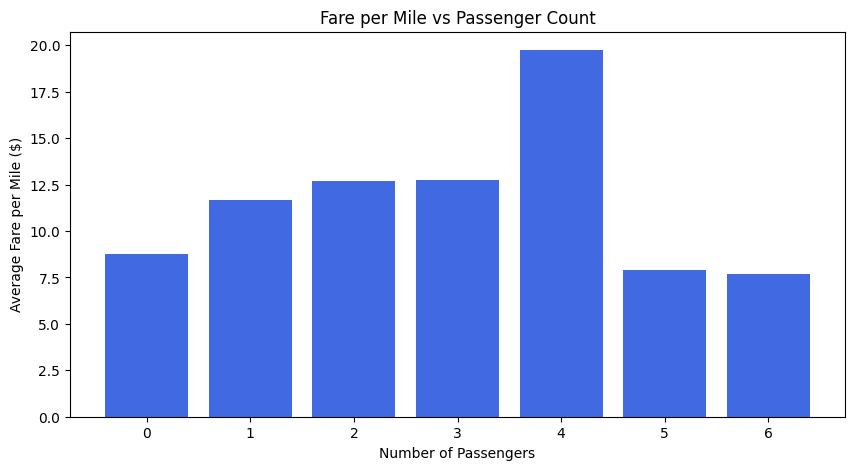

In [63]:
# Analyse the fare per mile per passenger for different passenger counts
# Remove trips with zero or negative distance to avoid errors
df_filtered = df_filtered[df_filtered['trip_distance'] > 0]
df_filtered.head()

# Calculate fare per mile
df_filtered['fare_per_mile'] = df_filtered['fare_amount'] / df_filtered['trip_distance']
df_filtered.head()

# Group by passenger count and calculate average fare per mile
fare_analysis = df_filtered.groupby('passenger_count')['fare_per_mile'].mean().reset_index()

# Display results
print(fare_analysis)

# Plot the fare per mile for different passenger counts
plt.figure(figsize=(10, 5))
plt.bar(fare_analysis['passenger_count'], fare_analysis['fare_per_mile'], color='royalblue')
plt.xlabel('Number of Passengers')
plt.ylabel('Average Fare per Mile ($)')
plt.title('Fare per Mile vs Passenger Count')
plt.xticks(fare_analysis['passenger_count'])
plt.show()

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

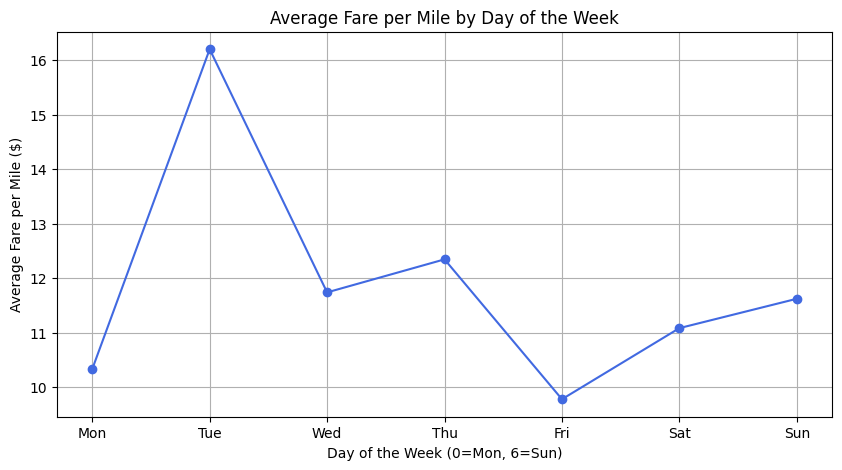

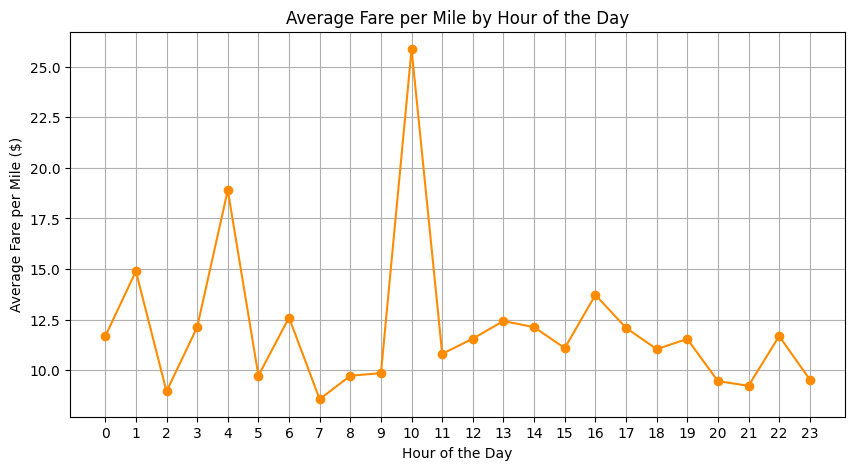

In [64]:
# Compare the average fare per mile for different days and for different times of the day

# Extract day of the week (0 = Monday, 6 = Sunday) and hour of day
df_filtered['day_of_week'] = df_filtered['tpep_pickup_datetime'].dt.dayofweek
df_filtered['hour_of_day'] = df_filtered['tpep_pickup_datetime'].dt.hour

fare_by_day = df_filtered.groupby('day_of_week')['fare_per_mile'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(fare_by_day['day_of_week'], fare_by_day['fare_per_mile'], marker='o', linestyle='-', color='royalblue')
plt.xlabel('Day of the Week (0=Mon, 6=Sun)')
plt.ylabel('Average Fare per Mile ($)')
plt.title('Average Fare per Mile by Day of the Week')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid()
plt.show()


fare_by_hour = df_filtered.groupby('hour_of_day')['fare_per_mile'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(fare_by_hour['hour_of_day'], fare_by_hour['fare_per_mile'], marker='o', linestyle='-', color='darkorange')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Fare per Mile ($)')
plt.title('Average Fare per Mile by Hour of the Day')
plt.xticks(range(24))
plt.grid()
plt.show()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

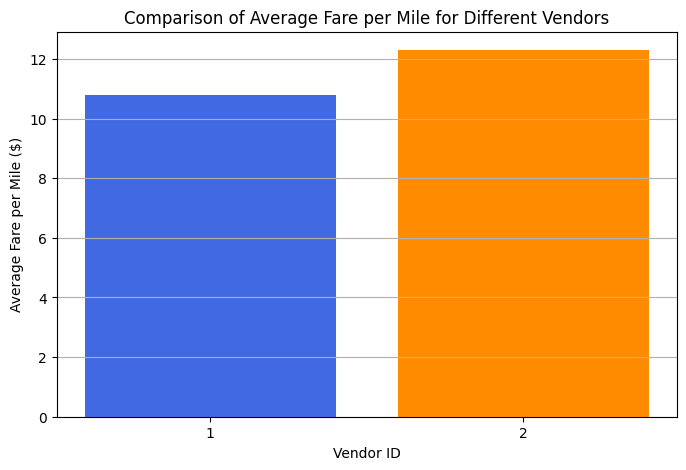

In [65]:
# Compare fare per mile for different vendors
df_filtered.columns
fare_by_vendor = df_filtered.groupby('VendorID')['fare_per_mile'].mean().reset_index()
plt.figure(figsize=(8, 5))
plt.bar(fare_by_vendor['VendorID'], fare_by_vendor['fare_per_mile'], color=['royalblue', 'darkorange'])
plt.xlabel('Vendor ID')
plt.ylabel('Average Fare per Mile ($)')
plt.title('Comparison of Average Fare per Mile for Different Vendors')
plt.xticks(fare_by_vendor['VendorID'])
plt.grid(axis='y')
plt.show()

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


<Figure size 1000x600 with 0 Axes>

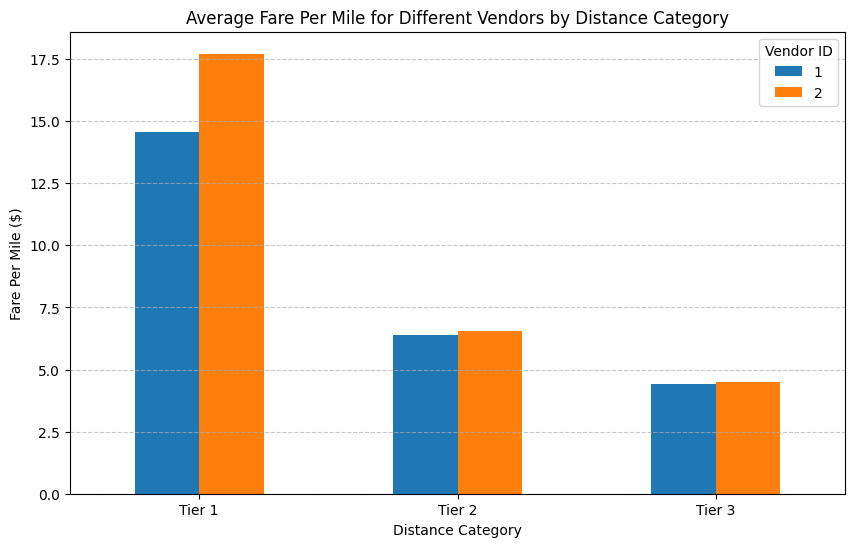

In [66]:
# Defining distance tiers

def categorize(distance):
    if distance <= 2:
        return 'Tier 1'
    elif 2 < distance <= 5:
        return 'Tier 2'
    else:
        return 'Tier 3'


# Apply the function to create a new column
df_filtered['distance_tier'] = df_filtered['trip_distance'].apply(categorize)
df_filtered.head()

fare_analysis = df_filtered.groupby(["VendorID", "distance_tier"])["fare_per_mile"].mean().reset_index()
# Pivot the data for better visualization
pivot_table = fare_analysis.pivot(index="distance_tier", columns="VendorID", values="fare_per_mile")

# Plot the data using a bar plot
plt.figure(figsize=(10, 6))
pivot_table.plot(kind="bar", figsize=(10, 6))
plt.title("Average Fare Per Mile for Different Vendors by Distance Category")
plt.ylabel("Fare Per Mile ($)")
plt.xlabel("Distance Category")
plt.xticks(rotation=0)
plt.legend(title="Vendor ID")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

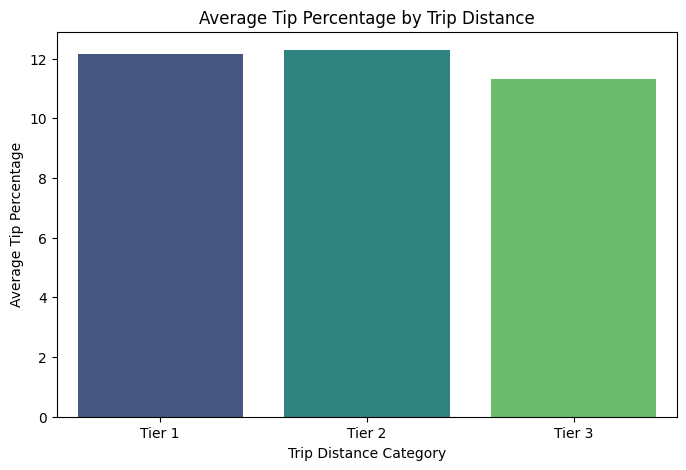

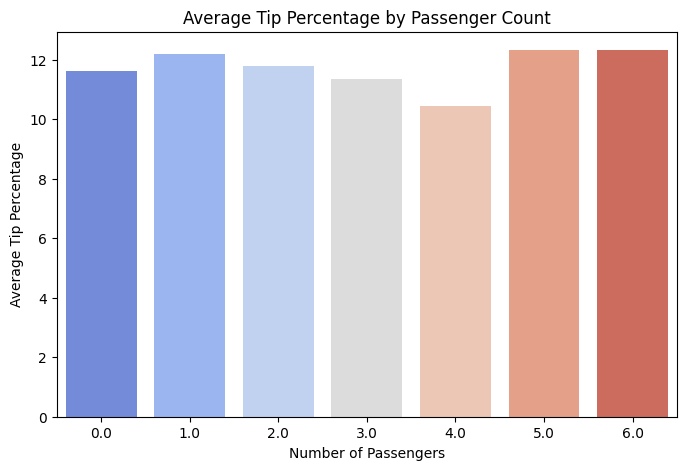

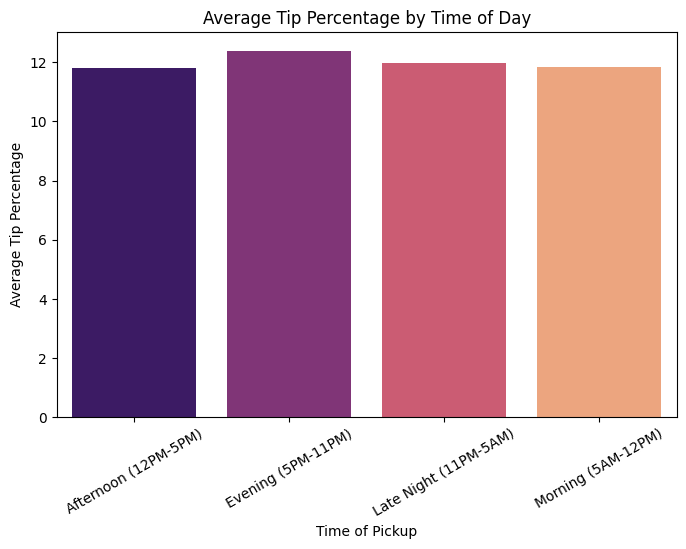

In [67]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
df_filtered.columns
df_filtered['tip_percentage'] = (df_filtered['tip_amount'] / df_filtered['total_amount'])*100
df_filtered.head()
# tip_analysis = df_filtered.groupby(['passenger_count', 'distance_tier'])['avg_tips'].mean().reset_index()
distance_tips = df_filtered.groupby("distance_tier")["tip_percentage"].mean().reset_index()
# Plot Tip Percentage vs. Trip Distance
plt.figure(figsize=(8, 5))
sns.barplot(x="distance_tier", y="tip_percentage", data=distance_tips, palette="viridis")
plt.title("Average Tip Percentage by Trip Distance")
plt.xlabel("Trip Distance Category")
plt.ylabel("Average Tip Percentage")
plt.show()

passenger_tips = df_filtered.groupby("passenger_count")["tip_percentage"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x="passenger_count", y="tip_percentage", data=passenger_tips, palette="coolwarm")
plt.title("Average Tip Percentage by Passenger Count")
plt.xlabel("Number of Passengers")
plt.ylabel("Average Tip Percentage")
plt.show()

df_filtered["time_category"] = df_filtered["pickup_hour"].apply(
    lambda x: "Morning (5AM-12PM)" if 5 <= x < 12 else
              "Afternoon (12PM-5PM)" if 12 <= x < 17 else
              "Evening (5PM-11PM)" if 17 <= x < 23 else
              "Late Night (11PM-5AM)"
)
time_tips = df_filtered.groupby("time_category")["tip_percentage"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x="time_category", y="tip_percentage", data=time_tips, palette="magma")
plt.title("Average Tip Percentage by Time of Day")
plt.xlabel("Time of Pickup")
plt.ylabel("Average Tip Percentage")
plt.xticks(rotation=30)
plt.show()

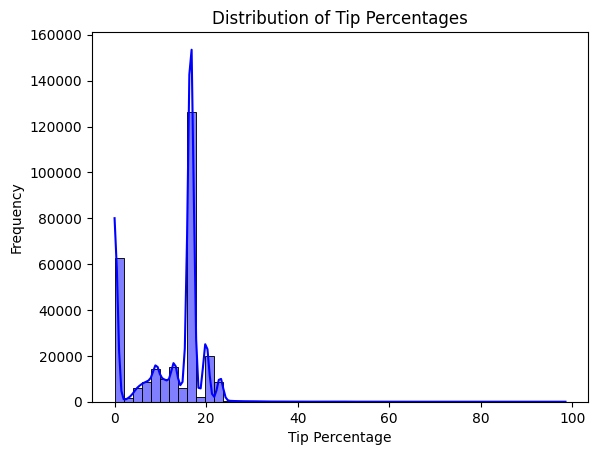

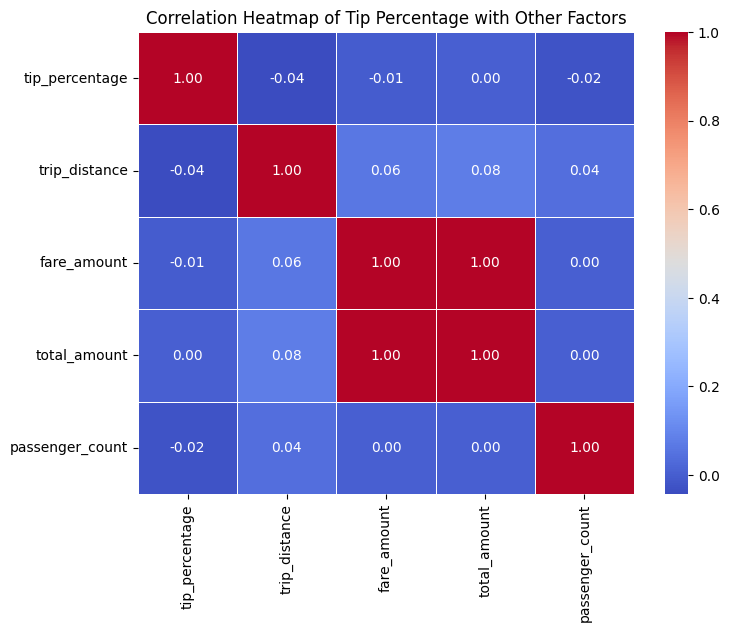

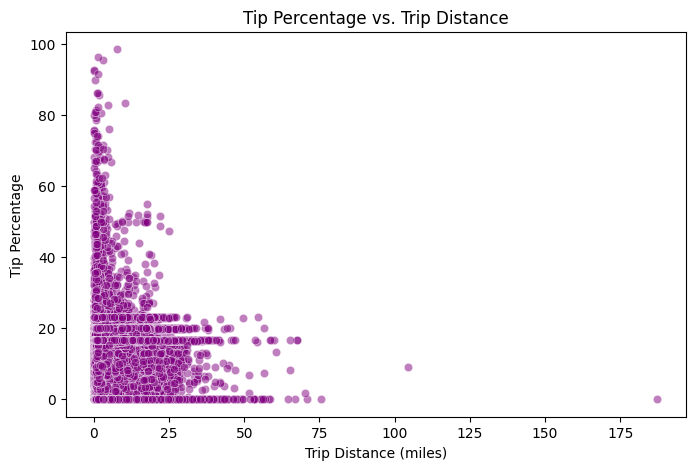

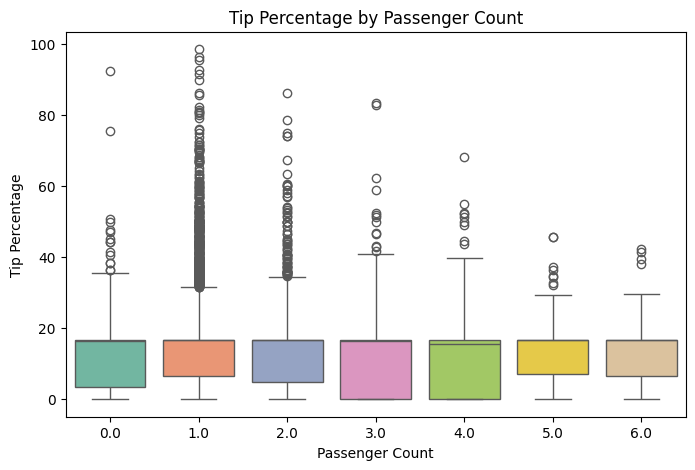

In [68]:
sns.histplot(df_filtered['tip_percentage'],bins=50,kde=True,color = 'blue')
plt.title('Distribution of Tip Percentages')
plt.xlabel('Tip Percentage')
plt.ylabel('Frequency')
plt.show()
# Selecting relevant numerical features
corr_features = ["tip_percentage", "trip_distance", "fare_amount", "total_amount", "passenger_count"]
corr_matrix = df_filtered[corr_features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Tip Percentage with Other Factors")
plt.show()


plt.figure(figsize=(8,5))
sns.scatterplot(x=df_filtered["trip_distance"], y=df_filtered["tip_percentage"], alpha=0.5, color="purple")
plt.title("Tip Percentage vs. Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Tip Percentage")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=df_filtered["passenger_count"], y=df_filtered["tip_percentage"], palette="Set2")
plt.title("Tip Percentage by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Tip Percentage")
plt.show()


Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

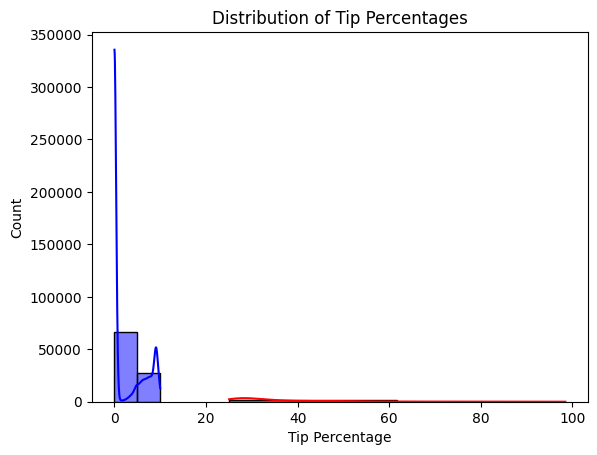

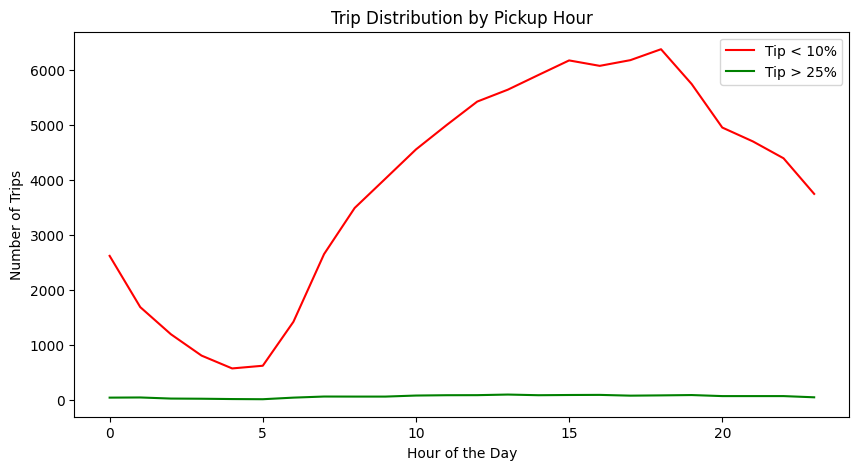

In [69]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%
low_tip_trips = df_filtered[df_filtered['tip_percentage'] < 10]
high_tip_trips = df_filtered[df_filtered['tip_percentage'] > 25]

sns.histplot(low_tip_trips['tip_percentage'], bins=2, kde=True, color='blue', label='Low Tip Percentage')
sns.histplot(high_tip_trips['tip_percentage'], bins=2, kde=True, color='red', label='High Tip Percentage')
plt.title('Distribution of Tip Percentages')
plt.xlabel('Tip Percentage')

low_tip_hours = low_tip_trips['hour_of_day'].value_counts().sort_index()
high_tip_hours = high_tip_trips['hour_of_day'].value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.plot(low_tip_hours.index, low_tip_hours.values, label='Tip < 10%', color='red')
plt.plot(high_tip_hours.index, high_tip_hours.values, label='Tip > 25%', color='green')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Trip Distribution by Pickup Hour')
plt.legend()
plt.show()


**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

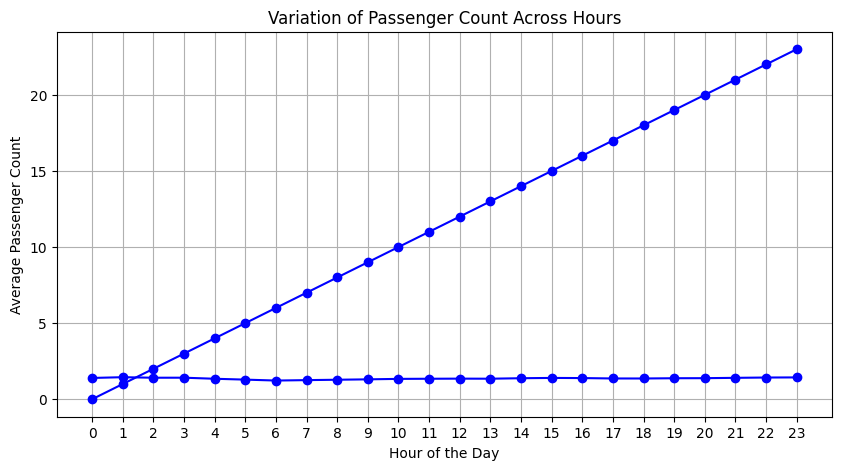

In [70]:
# See how passenger count varies across hours and days
hourly_pass_count = df_filtered.groupby('hour_of_day')['passenger_count'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(hourly_pass_count.index, hourly_pass_count.values, marker='o', color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Passenger Count')
plt.title('Variation of Passenger Count Across Hours')
plt.xticks(range(24))
plt.grid()
plt.show()


**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

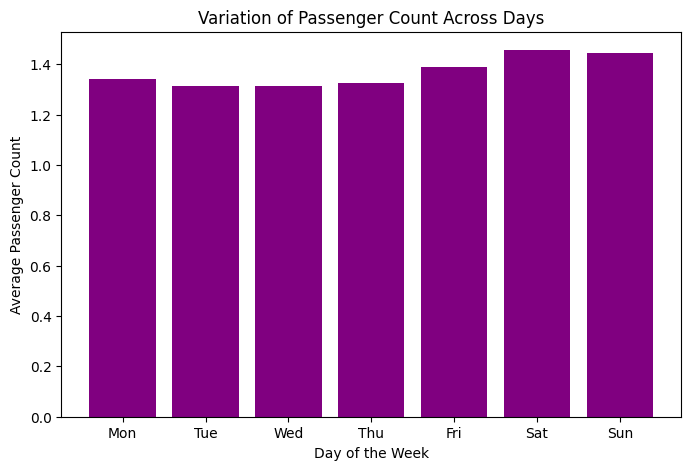

In [71]:
# How does passenger count vary across zones
daily_passenger_count = df_filtered.groupby('day_of_week')['passenger_count'].mean()

plt.figure(figsize=(8,5))
plt.bar(daily_passenger_count.index, daily_passenger_count.values, color='purple')
plt.xlabel('Day of the Week')
plt.ylabel('Average Passenger Count')
plt.title('Variation of Passenger Count Across Days')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


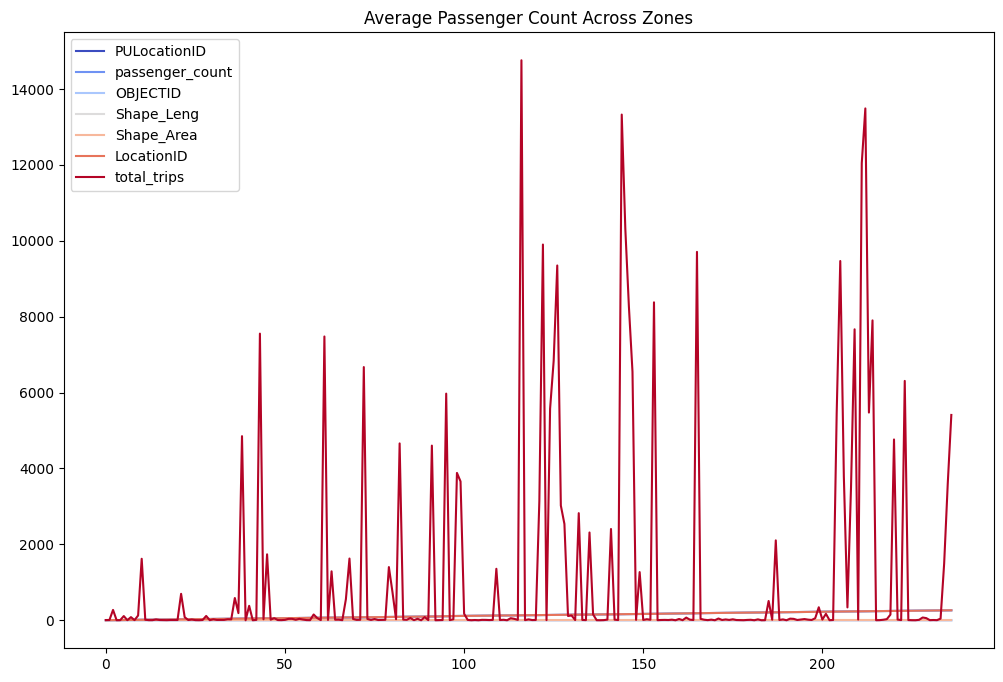

In [72]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

zone_passenger_count = df_filtered.groupby('PULocationID')['passenger_count'].mean().reset_index()
zone_passenger_count = zone_passenger_count.merge(zones, left_on='PULocationID', right_on='LocationID')

# Plot the passenger count across different zones
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
zone_passenger_count.plot(column='passenger_count', ax=ax, legend=True, cmap='coolwarm')
plt.title("Average Passenger Count Across Zones")
plt.show()


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

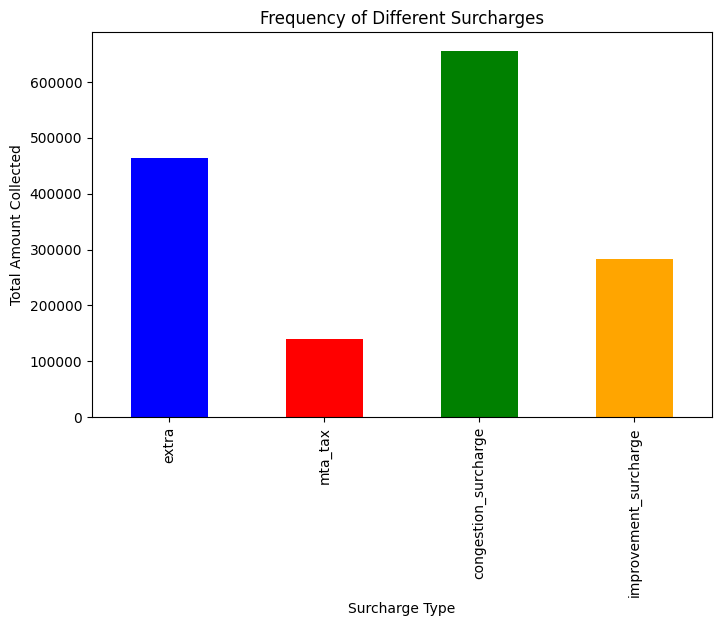

In [73]:
# How often is each surcharge applied?
surcharge_counts = df_filtered[['extra', 'mta_tax', 'congestion_surcharge', 'improvement_surcharge']].sum()

plt.figure(figsize=(8,5))
surcharge_counts.plot(kind='bar', color=['blue', 'red', 'green', 'orange'])
plt.xlabel('Surcharge Type')
plt.ylabel('Total Amount Collected')
plt.title('Frequency of Different Surcharges')
plt.show()



## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

In [74]:

# peak hours analysis

# demand patterns directs to the high use of taxis during 14 to 19 hours based on the Peak hours analysis.
# increase fleet availblity during 14 to 19hrs of the weekdays
# More single passenger trips on weekdays hence smaller vehicles/rides-sharing can be done
# On weekends group travel is more hence minivans/SUV's can be used.


# Zone-Based Demand
# high-demand business areas, airports, and nightlife districts.
# Increase dispatching resources to these hotspots.

# operational efficeincy
# Use real-time data to dispatch taxis closer to upcoming demand zones.
# Incentivize drivers to wait in high-probability pickup areas.
# Implement dynamic routing to avoid traffic congestion and reduce trip times.
# Use AI-based dispatching to assign the nearest available vehicle to minimize waiting time.
# Pre-position vehicles in zones with expected surge using historical data.
# Use predictive analytics to pre-load dispatch schedules based on time-of-day demand.
# Offer extra payouts for pickups in less popular zones to balance supply.
# Encourage shorter breaks during peak hours to maximize trip coverage.





**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

In [75]:
# Morning Peak (7 AM – 10 AM)

# High demand in residential areas → Position cabs in suburban locations to facilitate work commutes.

# Increased demand at transport hubs (train stations, bus terminals, airports) → Ensure coverage in these zones.


# Evening Peak (5 PM – 9 PM)

# Focus on office districts and commercial hubs as workers commute home.

# High activity around shopping centers and restaurants → Pre-position cabs near malls, business districts, and entertainment zones.


# Late Night (11 PM – 5 AM)

# High trip volume near nightlife districts (bars, clubs, casinos) → Station cabs near nightlife hotspots.

# Increased drop-offs at residential zones → Ensure availability in key exit routes from entertainment areas.




**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

In [76]:
# 1. Demand-Based Dynamic Pricing
# Implement higher rates during peak demand hours (morning/evening rush, weekends, bad weather).

# Keep pricing lower during off-peak times to encourage more bookings.

# 2. Location-Based Surge Pricing
# Increase rates at high-demand pickup locations (airports, business districts, nightlife zones) during peak hours.

# Maintain normal fares in low-demand zones to avoid passenger loss.

# 3. Distance-Based Fare Adjustments
# For short trips (< 2 miles):

# Keep base fare competitive to encourage more rides.

# For medium trips (2-5 miles):

# Maintain balanced pricing while offering small discounts to retain customers.

# For long-distance trips (> 5 miles):

# Introduce flat fares or promotional discounts to attract long-haul passengers.

# 4. Passenger-Based Pricing
# Solo travelers → Standard pricing.

# Group trips (3+ passengers) → Slightly lower per-person cost to encourage shared rides.